In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U flash-attn --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
CONTEXT_LENGTH = 4096
REPO_NAME = 'experimental-JP47D55'

In [ ]:
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments, GenerationMixin, AutoModelForCausalLM
from transformers import PreTrainedTokenizerFast
from transformers import LlamaTokenizer
from transformers import DataCollatorWithPadding
from transformers import pipeline
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from datasets import Dataset
from datetime import datetime
import datasets
import random
import os
import json
import numpy as np
import pandas as pd

In [ ]:
CPU_COUNT = os.cpu_count()
print(f"Number of CPUs: {CPU_COUNT}")

Number of CPUs: 12


In [ ]:
REQUIRED_FIELD = 'text'
datasets.disable_caching()

In [ ]:
lami = load_dataset("MBZUAI/LaMini-instruction")
lami = lami.map(lambda example:
    {REQUIRED_FIELD: f"<|user|>"+example['instruction']+f"<|end|><|assistant|>"+example['response']+f"<|end|>"},
    num_proc=CPU_COUNT)
lami = lami.remove_columns(["instruction", "response", "instruction_source"])
lami

README.md:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

(…)-00000-of-00003-929c6c373c0473cd.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

(…)-00001-of-00003-1f823c156c353d51.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00003-752db5e1576f5089.parquet:   0%|          | 0.00/253M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2585615 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/2585615 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2585615
    })
})

In [ ]:
def map_messages_into_str(messages):
  str = ''
  for message in messages:
    content = message['content']
    role = '<|'+message['role']+'|>'
    str += role+content+'<|end|>'
  return str

In [ ]:
tinyds = datasets.concatenate_datasets([lami['train']])
tinyds

Dataset({
    features: ['text'],
    num_rows: 2585615
})

In [ ]:
# """
tinyds = tinyds.map(lambda example:
    {REQUIRED_FIELD:
    example[REQUIRED_FIELD].replace(f"|>\n","|>").replace(f"/n<|","<|").strip()},num_proc=CPU_COUNT)
print(len(tinyds))
tinyds = tinyds.filter(lambda example: 'I am not' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: 'I am an AI' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: 'I do not' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: 'I cannot' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: 't goes against my' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: 't is not my' not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
tinyds = tinyds.filter(lambda example: "I don't have" not in example[REQUIRED_FIELD],num_proc=CPU_COUNT)
print(len(tinyds))
# """

Map (num_proc=12):   0%|          | 0/2585615 [00:00<?, ? examples/s]

2585615


Filter (num_proc=12):   0%|          | 0/2585615 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2581277 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2577271 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2566219 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2530181 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2529923 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/2529882 [00:00<?, ? examples/s]

2520658


In [ ]:
tinyds_all = tinyds.train_test_split(test_size=5000, seed=42)  # Using seed for reproducibility
tinyds_train = tinyds_all['train']
tinyds_validation = tinyds_all['test']
# tinyds = None
tinyds_all = None

In [ ]:
def printIfFind(str):
  # print str if it contains "[YOUR NAME]"
  if "YOUR NAME" in str:
    print(str)
    str = str.replace("YOUR NAME", "KPhi-3")

  # if "AI assistant" in str:
  #  print(str)

  return str

# tinyds = tinyds.map(lambda example:
#    {REQUIRED_FIELD: printIfFind(example[REQUIRED_FIELD])},num_proc=CPU_COUNT)

In [ ]:
lami = False
orca = False
english = False
smoltalk = False
oai = False
all_datasets = False
merged_dataset = False

In [ ]:
TINYDS_SIZE = len(tinyds_train)
print('Train size:', tinyds_train)
TINYDS_SIZE_VALIDATION = len(tinyds_validation)
print('Test size:', tinyds_validation)

Train size: Dataset({
    features: ['text'],
    num_rows: 2515658
})
Test size: Dataset({
    features: ['text'],
    num_rows: 5000
})


In [ ]:
hf_tokenizer = LlamaTokenizer.from_pretrained("schuler/"+ "experimental-JP47D20") # REPO_NAME
VOCAB_SIZE = hf_tokenizer.vocab_size + 64
data_collator = DataCollatorWithPadding(tokenizer=hf_tokenizer)

tokenizer_config.json:   0%|          | 0.00/3.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

In [ ]:
# prompt: With tokenizer, tokenize the sentence "hello world"

tokenized_text = hf_tokenizer.encode("hello world", max_length=CONTEXT_LENGTH, padding='max_length')
print(tokenized_text,'',len(tokenized_text))

[22172, 3186, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,

In [ ]:
hf_tokenizer.max_length = CONTEXT_LENGTH
hf_tokenizer.model_max_length = CONTEXT_LENGTH
def tokenize_function2(example):
    return hf_tokenizer(example["text"], truncation=True, max_length=CONTEXT_LENGTH, padding='max_length')

In [ ]:
def find_first_end_index(start_idx, end_indices):
    for end_idx in end_indices:
        if end_idx > start_idx:
            return end_idx
    return -1  # Return -1 if no such end_index is found

def replace_between_tokens(
  tokenized_text,
  start_token_id: int = 32010,
  end_token_id: int = 32007,
  replace_value: int = -100
  ):
  """
  Replace all values between and including start_token and end_token with replace_value.
  Args:
      tokenized_text: Input list containing token IDs
      start_token_id: Token ID marking the start of replacement range
      end_token_id: Token ID marking the end of replacement range
      replace_value: Value to replace tokens with

  Returns:
      Modified tensor with values replaced between start and end tokens
  """
  tokenized_text_array = np.array(tokenized_text)
  # print(tokenized_text_array.shape, len(tokenized_text_array.shape))
  # hello()

  # Find indices where the start and end tokens occur
  start_indices = (tokenized_text_array == start_token_id).nonzero()[0]
  end_indices = (tokenized_text_array == end_token_id).nonzero()[0]
  pos_len = min(len(start_indices), len(end_indices))
  if pos_len > 0:
    for i in range(pos_len):
        start_idx = start_indices[i].item()
        end_idx = find_first_end_index(start_idx, end_indices)
        # print('(',start_idx,'-',end_idx,')')
        if end_idx > start_idx:
            tokenized_text_array[start_idx:end_idx+1] = replace_value
    return list(tokenized_text_array)
  else:
    return tokenized_text

def clean_system_user(tokenized_text):
  tokenized_text = replace_between_tokens(tokenized_text, 32006, 32007)
  tokenized_text = replace_between_tokens(tokenized_text)
  return tokenized_text

In [ ]:
# https://github.com/huggingface/transformers/tree/v4.46-release/src/transformers/models/phi3

In [ ]:
import math
import warnings
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss, BCELoss, BCEWithLogitsLoss

from transformers.activations import ACT2FN
from transformers.generation import GenerationMixin
from transformers.modeling_attn_mask_utils import AttentionMaskConverter
from transformers.cache_utils import Cache, DynamicCache, SlidingWindowCache, StaticCache
from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
    # QuestionAnsweringModelOutput,
    SequenceClassifierOutputWithPast,
    TokenClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    is_flash_attn_2_available,
    is_flash_attn_greater_or_equal_2_10,
    logging,
    replace_return_docstrings,
)
from transformers.configuration_utils import PretrainedConfig
from transformers.utils import logging

if is_flash_attn_2_available():
    from transformers.modeling_flash_attention_utils import _flash_attention_forward

logger = logging.get_logger(__name__)

In [ ]:
class KPhi3Config(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`Phi3Model`]. It is used to instantiate a Phi-3
    model according to the specified arguments, defining the model architecture. Instantiating a configuration with the
    defaults will yield a similar configuration to that of the
    [microsoft/Phi-3-mini-4k-instruct](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct).

    Configuration objects inherit from [`PretrainedConfig`] and can be used to control the model outputs. Read the
    documentation from [`PretrainedConfig`] for more information.

    Args:
        vocab_size (`int`, *optional*, defaults to 32064):
            Vocabulary size of the Phi-3 model. Defines the number of different tokens that can be represented by the
            `inputs_ids` passed when calling [`Phi3Model`].
        hidden_size (`int`, *optional*, defaults to 3072):
            Dimension of the hidden representations.
        intermediate_size (`int`, *optional*, defaults to 8192):
            Dimension of the MLP representations.
        num_hidden_layers (`int`, *optional*, defaults to 32):
            Number of hidden layers in the Transformer decoder.
        num_attention_heads (`int`, *optional*, defaults to 32):
            Number of attention heads for each attention layer in the Transformer decoder.
        num_key_value_heads (`int`, *optional*):
            This is the number of key_value heads that should be used to implement Grouped Query Attention. If
            `num_key_value_heads=num_attention_heads`, the model will use Multi Head Attention (MHA), if
            `num_key_value_heads=1` the model will use Multi Query Attention (MQA) otherwise GQA is used. When
            converting a multi-head checkpoint to a GQA checkpoint, each group key and value head should be constructed
            by meanpooling all the original heads within that group. For more details checkout [this
            paper](https://arxiv.org/pdf/2305.13245.pdf). If it is not specified, will default to
            `num_attention_heads`.
        resid_pdrop (`float`, *optional*, defaults to 0.0):
            Dropout probability for mlp outputs.
        embd_pdrop (`int`, *optional*, defaults to 0.0):
            The dropout ratio for the embeddings.
        attention_dropout (`float`, *optional*, defaults to 0.0):
            The dropout ratio after computing the attention scores.
        hidden_act (`str` or `function`, *optional*, defaults to `"silu"`):
            The non-linear activation function (function or string) in the decoder.
        max_position_embeddings (`int`, *optional*, defaults to 4096):
            The maximum sequence length that this model might ever be used with.
        original_max_position_embeddings (`int`, *optional*, defaults to 4096):
            The maximum sequence length that this model was trained with. This is used to determine the size of the
            original RoPE embeddings when using long scaling.
        initializer_range (`float`, *optional*, defaults to 0.02):
            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
        rms_norm_eps (`float`, *optional*, defaults to 1e-05):
            The epsilon value used for the RMSNorm.
        use_cache (`bool`, *optional*, defaults to `True`):
            Whether or not the model should return the last key/values attentions (not used by all models). Only
            relevant if `config.is_decoder=True`. Whether to tie weight embeddings or not.
        tie_word_embeddings (`bool`, *optional*, defaults to `False`):
            Whether to tie weight embeddings
        rope_theta (`float`, *optional*, defaults to 10000.0):
            The base period of the RoPE embeddings.
        rope_scaling (`dict`, *optional*):
            The scaling strategy for the RoPE embeddings. If `None`, no scaling is applied. If a dictionary, it must
            contain the following keys: `type`, `short_factor` and `long_factor`. The `type` must be `longrope` and
            the `short_factor` and `long_factor` must be lists of numbers with the same length as the hidden size
            divided by the number of attention heads divided by 2.
        bos_token_id (`int`, *optional*, defaults to 1):
            The id of the "beginning-of-sequence" token.
        eos_token_id (`int`, *optional*, defaults to 32000):
            The id of the "end-of-sequence" token.
        pad_token_id (`int`, *optional*, defaults to 32000):
            The id of the padding token.
        sliding_window (`int`, *optional*):
            Sliding window attention window size. If `None`, no sliding window is applied.

    Example:

    ```python
    >>> from transformers import Phi3Model, Phi3Config

    >>> # Initializing a Phi-3 style configuration
    >>> configuration = Phi3Config.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

    >>> # Initializing a model from the configuration
    >>> model = Phi3Model(configuration)

    >>> # Accessing the model configuration
    >>> configuration = model.config
    ```"""

    model_type = "kphi3"
    keys_to_ignore_at_inference = ["past_key_values"]

    def __init__(
        self,
        vocab_size=32064,
        embed_size=512,
        hidden_size=2048,
        intermediate_size=8192,
        num_hidden_layers=32,
        num_attention_heads=32,
        num_key_value_heads=None,
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attention_dropout=0.0,
        hidden_act="silu",
        max_position_embeddings=4096,
        original_max_position_embeddings=4096,
        initializer_range=0.02,
        rms_norm_eps=1e-5,
        use_cache=True,
        tie_word_embeddings=False,
        rope_theta=10000.0,
        rope_scaling=None,
        bos_token_id=1,
        eos_token_id=32000,
        pad_token_id=32000,
        sliding_window=None,
        min_channels_per_group=32,
        **kwargs,
    ):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads

        if num_key_value_heads is None:
            num_key_value_heads = num_attention_heads

        self.num_key_value_heads = num_key_value_heads
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attention_dropout = attention_dropout
        self.hidden_act = hidden_act
        self.max_position_embeddings = max_position_embeddings
        self.original_max_position_embeddings = original_max_position_embeddings
        self.initializer_range = initializer_range
        self.rms_norm_eps = rms_norm_eps
        self.use_cache = use_cache
        self.rope_theta = rope_theta
        self.rope_scaling = rope_scaling
        self._rope_scaling_adjustment()
        self._rope_scaling_validation()
        self.sliding_window = sliding_window
        self.min_channels_per_group = min_channels_per_group

        super().__init__(
            bos_token_id=bos_token_id,
            eos_token_id=eos_token_id,
            pad_token_id=pad_token_id,
            tie_word_embeddings=tie_word_embeddings,
            **kwargs,
        )

    def _rope_scaling_adjustment(self):
        """
        Adjust the `type` of the `rope_scaling` configuration for backward compatibility.
        """
        if self.rope_scaling is None:
            return

        rope_scaling_type = self.rope_scaling.get("type", None)

        # For backward compatibility if previous version used "su" or "yarn"
        if rope_scaling_type is not None and rope_scaling_type in ["su", "yarn"]:
            self.rope_scaling["type"] = "longrope"

    def _rope_scaling_validation(self):
        """
        Validate the `rope_scaling` configuration.
        """
        if self.rope_scaling is None:
            return

        if not isinstance(self.rope_scaling, dict) or len(self.rope_scaling) != 3:
            raise ValueError(
                "`rope_scaling` must be a dictionary with three fields, `type`, `short_factor` and `long_factor`, "
                f"got {self.rope_scaling}"
            )
        rope_scaling_type = self.rope_scaling.get("type", None)
        rope_scaling_short_factor = self.rope_scaling.get("short_factor", None)
        rope_scaling_long_factor = self.rope_scaling.get("long_factor", None)
        if rope_scaling_type is None or rope_scaling_type not in ["longrope"]:
            raise ValueError(f"`rope_scaling`'s type field must be one of ['longrope'], got {rope_scaling_type}")
        if not (
            isinstance(rope_scaling_short_factor, list)
            and all(isinstance(x, (int, float)) for x in rope_scaling_short_factor)
        ):
            raise ValueError(
                f"`rope_scaling`'s short_factor field must be a list of numbers, got {rope_scaling_short_factor}"
            )
        if not len(rope_scaling_short_factor) == self.hidden_size // self.num_attention_heads // 2:
            raise ValueError(
                f"`rope_scaling`'s short_factor field must have length {self.hidden_size // self.num_attention_heads // 2}, got {len(rope_scaling_short_factor)}"
            )
        if not (
            isinstance(rope_scaling_long_factor, list)
            and all(isinstance(x, (int, float)) for x in rope_scaling_long_factor)
        ):
            raise ValueError(
                f"`rope_scaling`'s long_factor field must be a list of numbers, got {rope_scaling_long_factor}"
            )
        if not len(rope_scaling_long_factor) == self.hidden_size // self.num_attention_heads // 2:
            raise ValueError(
                f"`rope_scaling`'s long_factor field must have length {self.hidden_size // self.num_attention_heads // 2}, got {len(rope_scaling_long_factor)}"
            )


In [ ]:
def get_max_acceptable_common_divisor(a, b, max_acceptable=1000000):
  """
  This is an inefficient max acceptable common divisor implementation to be improved.
    # Arguments
        a: is an integer.
        b: is an integer.
        max_acceptable: maximum acceptable common divisor.
  """
  divisor = max(1, min(a, b, max_acceptable))
  while divisor > 0:
      if a % divisor == 0 and b % divisor == 0:
          return divisor
          break
      divisor -= 1

class InterleaveChannels(nn.Module):
    """
    This layer interleaves channels stepping according to the number passed as parameter.
    This layer assumes "channel last".
    """
    def __init__(self, step_size=2, last_dim=3):
        super().__init__()
        self.step_size = step_size if step_size >= 2 else 1
        self.last_dim = last_dim

    def forward(self, x):
      if (self.last_dim==3):
        return torch.cat([x[:, :, :, shift_pos::self.step_size] for shift_pos in range(self.step_size)], dim=3)
      else:
        if (self.last_dim==2):
          return torch.cat([x[:, :, shift_pos::self.step_size] for shift_pos in range(self.step_size)], dim=2)

def SignedSquareRoot1(x):
    """
    Custom activation function that implements:
    f(x) = sqrt(x)     for x > 1
    f(x) = sqrt(-x)    for x < -1
    f(x) = x           for -1 ≤ x ≤ 1
    """
    return torch.where(x > 1,
      torch.sqrt(x),
      torch.where(x < -1, torch.sqrt(-x), x)
    )

# coded by GPT o1 Preview
class InterleaveChannelsFast(nn.Module):
    """
    This layer interleaves channels stepping according to the number passed as parameter.
    This layer assumes "channel last".
    """
    def __init__(self, step_size=2, last_dim=3):
        super().__init__()
        self.step_size = max(step_size, 1)
        self.last_dim = last_dim

    def forward(self, x):
        if self.last_dim == 3:
            N, H, W, C = x.shape
            if C % self.step_size != 0:
                raise ValueError("Number of channels must be divisible by step_size")
            # Reshape to separate the interleaving groups
            x = x.view(N, H, W, self.step_size, C // self.step_size)
            # Transpose to interleave the channels
            x = x.permute(0, 1, 2, 4, 3)
            # Flatten back to the original shape
            x = x.reshape(N, H, W, C)
            return x
        elif self.last_dim == 2:
            N, H, W = x.shape
            if W % self.step_size != 0:
                raise ValueError("Width must be divisible by step_size")
            x = x.view(N, H, self.step_size, W // self.step_size)
            x = x.permute(0, 1, 3, 2)
            x = x.reshape(N, H, W)
            return x
        else:
            raise ValueError("last_dim must be 2 or 3")

class GroupedLinear(nn.Module):
    """
    Similarly to a grouped pointwise convolution, this layer is a grouped linear layer.
    This layer assumes "channel last".
    """
    def __init__(self, in_features, out_features, num_groups=1, bias=True):
            super().__init__()
            self.in_features = in_features
            self.out_features = out_features
            self.num_groups = num_groups
            self.bias = bias

            # Check if input features are divisible by num_groups
            if in_features % num_groups != 0:
                raise ValueError("Input features must be divisible by num_groups.")
            if out_features % num_groups != 0:
                raise ValueError("Output features must be divisible by num_groups.")

            self.in_features_per_group = in_features // num_groups
            self.out_features_per_group = out_features // num_groups

            # Create individual linear layers for each group
            self.group_layers = nn.ModuleList([
                nn.Linear(self.in_features_per_group, self.out_features_per_group, bias=bias)
                for _ in range(num_groups)
            ])

    def forward(self, x):
            # print('input:',x.shape,' in:',self.in_features,' out:',self.out_features,
            #  ' groups:',self.num_groups,
            #  ' in_per_group:',self.in_features_per_group,
            #  ' out_per_group:',self.out_features_per_group,
            #  ' bias:',self.bias
            #)
            if self.in_features != x.shape[-1]:
                raise ValueError(
                    "GroupedLinear error: "+
                    "expected in_feautures "+str(self.in_features)+
                    " but got "+str(x.shape[-1])
                 )
            # Split the input tensor into groups along the last dimension
            x_groups = x.chunk(self.num_groups, dim=-1)

            # for i, tensor in enumerate(x_groups):
            #  print(f'x_groups[{i}]: {tensor.shape}')

            # Apply individual linear layers to each group
            out_groups = [layer(group) for layer, group in zip(self.group_layers, x_groups)]

            # Concatenate the output groups along the last dimension
            out = torch.cat(out_groups, dim=-1)
            if self.out_features != out.shape[-1]:
                raise ValueError(
                    "GroupedLinear error: "+
                    "expected out_feautures "+str(self.out_features)+
                    " but got "+str(out.shape[-1])
                 )
            # print('output:',out.shape)
            return out

class GroupedLinearFast(nn.Module):
    """
    Optimized grouped linear layer.
    This layer assumes "channel last".
    """
    def __init__(self, in_features, out_features, num_groups=1, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_groups = num_groups

        # Validate divisibility
        if in_features % num_groups != 0:
            raise ValueError("Input features must be divisible by num_groups.")
        if out_features % num_groups != 0:
            raise ValueError("Output features must be divisible by num_groups.")

        self.in_features_per_group = in_features // num_groups
        self.out_features_per_group = out_features // num_groups

        # Initialize weight and bias parameters
        self.weight = nn.Parameter(
            torch.Tensor(num_groups, self.in_features_per_group, self.out_features_per_group)
        )
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_groups, self.out_features_per_group))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        # Weight initialization
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            # Bias initialization
            fan_in = self.in_features_per_group
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        in_shape = x.shape
        if x.shape[-1] != self.in_features:
            raise ValueError(
                f"GroupedLinear error: expected in_features {self.in_features}, but got {x.shape[-1]}"
            )
        # Reshape input to separate groups
        x = x.view(*x.shape[:-1], self.num_groups, self.in_features_per_group)

        # print('in shape', in_shape)
        # print('x shape', x.shape)
        # print('weight shape', self.weight.shape)

        # Perform batch matrix multiplication
        # x shape: [..., num_groups, in_features_per_group]
        # weight shape: [num_groups, in_features_per_group, out_features_per_group]
        # out = torch.matmul(x, self.weight)
        out = torch.einsum('...ni,niq->...nq', x, self.weight)
        # print('out shape', out.shape)
        # print(in_shape[0], in_shape[1], self.out_features)

        # Add bias if present
        if self.bias is not None:
            out += self.bias

        # Reshape output back to original shape
        # out = out.view(in_shape[0], in_shape[1], self.out_features)
        out = out.contiguous().view(*out.shape[:-2], self.out_features)
        return out

class GroupedPointwiseConvolutionBlock(nn.Module):
    """
    This layer is composed by a grouped pointwise convolution followed by interleaving and another grouped pointwise comvolution with skip connection. This basic architecture can
    vary according to the input tensor and its parameters. This is the basic building block for the papers:
    https://www.researchgate.net/publication/360226228_Grouped_Pointwise_Convolutions_Reduce_Parameters_in_Convolutional_Neural_Networks
    https://www.researchgate.net/publication/355214501_Grouped_Pointwise_Convolutions_Significantly_Reduces_Parameters_in_EfficientNet
    This layer assumes "channel last".
    """
    def __init__(self, in_features, out_features, min_channels_per_group=32, last_dim=2, use_bias=False, activation=None, has_batch_norm=False, has_batch_scale=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.min_channels_per_group = min_channels_per_group
        self.last_dim = last_dim
        self.activation = activation
        self.has_batch_norm = has_batch_norm
        self.has_batch_scale = has_batch_scale
        self.has_interleaving = False
        self.use_bias = use_bias
        self.grouped = False
        self.second_conv = False
        self.first_pointwise_conv = None
        self.second_pointwise_conv = None
        self.interleave_layer = None
        # this is a hack to prevent runtime errors
        self.weight = torch.Tensor(1, 1, 1)
        self.bias = torch.Tensor(1, 1, 1)

        prev_layer_channel_count = in_features
        output_channel_count = out_features
        max_acceptable_divisor = (prev_layer_channel_count//min_channels_per_group)
        group_count = get_max_acceptable_common_divisor(prev_layer_channel_count, output_channel_count, max_acceptable = max_acceptable_divisor)
        if group_count is None: group_count=1
        self.output_group_size = output_channel_count // group_count
        # input_group_size = prev_layer_channel_count // group_count

        if (group_count>1):
            self.grouped = True
            #print ('Input channels:', prev_layer_channel_count, 'Output Channels:',output_channel_count,'Groups:', group_count, 'Input channels per group:', input_group_size, 'Output channels per group:', output_group_size)
            # conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias, strides=(stride_size, stride_size), padding=padding)
            # self.first_pointwise_conv = GroupedLinear(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
            self.first_pointwise_conv = GroupedLinearFast(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
            if self.output_group_size > 1:
                self.has_interleaving = True
                self.interleave_layer = InterleaveChannelsFast(self.output_group_size, last_dim=last_dim)
            if (prev_layer_channel_count >= output_channel_count):
                # print('Has intergroup')
                self.second_conv = True
                # conv2d_bn(output_tensor, output_channel_count, 1, 1, name=name+'_group_interconn', activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias)
                # self.second_pointwise_conv = GroupedLinear(in_features=out_features, out_features=out_features, num_groups=group_count, bias=use_bias)
                self.second_pointwise_conv = GroupedLinearFast(in_features=out_features, out_features=out_features, num_groups=group_count, bias=use_bias)
        else:
            #print ('Dismissed groups:', group_count, 'Input channels:', prev_layer_channel_count, 'Output Channels:', output_channel_count, 'Input channels per group:', input_group_size, 'Output channels per group:', output_group_size)
            #self.first_pointwise_conv = conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias)
            self.first_pointwise_conv = GroupedLinear(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)

    def forward(self, x):
      if (self.grouped):
        output_tensor = self.first_pointwise_conv(x)
        if self.activation is not None:
          output_tensor = self.activation(output_tensor)
        compression_tensor = output_tensor
        if self.has_interleaving:
          output_tensor = self.interleave_layer(output_tensor)
        if self.second_conv:
          output_tensor = self.second_pointwise_conv(output_tensor)
          if self.activation is not None:
            output_tensor = self.activation(output_tensor)
          output_tensor = output_tensor + compression_tensor
      else:
        output_tensor = self.first_pointwise_conv(x)
        if self.activation is not None:
            output_tensor = self.activation(output_tensor)
      return output_tensor

class GroupedPointwiseConvolutionBlockIO(nn.Module):
    """
    This layer is composed by a grouped pointwise convolution followed by interleaving and another grouped pointwise comvolution with skip connection. This basic architecture can
    vary according to the input tensor and its parameters. This is the basic building block for the papers:
    https://www.researchgate.net/publication/360226228_Grouped_Pointwise_Convolutions_Reduce_Parameters_in_Convolutional_Neural_Networks
    https://www.researchgate.net/publication/355214501_Grouped_Pointwise_Convolutions_Significantly_Reduces_Parameters_in_EfficientNet
    This layer assumes "channel last".
    """
    def __init__(self, in_features, out_features, min_channels_per_group=32, last_dim=2, use_bias=False, activation=None, has_batch_norm=False, has_batch_scale=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.min_channels_per_group = min_channels_per_group
        self.last_dim = last_dim
        self.activation = activation
        self.has_batch_norm = has_batch_norm
        self.has_batch_scale = has_batch_scale
        self.has_interleaving = False
        self.use_bias = use_bias
        self.grouped = False
        self.second_conv = False
        self.first_pointwise_conv = None
        self.second_pointwise_conv = None
        self.interleave_layer = None
        # this is a hack to prevent runtime errors
        self.weight = torch.Tensor(1, 1, 1)
        self.bias = torch.Tensor(1, 1, 1)

        prev_layer_channel_count = in_features
        output_channel_count = out_features
        max_acceptable_divisor = (prev_layer_channel_count//min_channels_per_group)
        group_count = get_max_acceptable_common_divisor(prev_layer_channel_count, output_channel_count, max_acceptable = max_acceptable_divisor)
        if group_count is None: group_count=1
        self.output_group_size = output_channel_count // group_count
        self.input_group_size = prev_layer_channel_count // group_count

        if (group_count>1):
            self.grouped = True
            self.has_interleaving = True
            self.second_conv = True
            #print ('Input channels:', prev_layer_channel_count, 'Output Channels:',output_channel_count,'Groups:', group_count, 'Input channels per group:', input_group_size, 'Output channels per group:', output_group_size)
            # conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias, strides=(stride_size, stride_size), padding=padding)
            # self.first_pointwise_conv = GroupedLinear(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
            self.first_pointwise_conv = GroupedLinearFast(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
            self.interleave_layer = InterleaveChannelsFast(self.input_group_size, last_dim=last_dim)
            # print('Has intergroup')
            # conv2d_bn(output_tensor, output_channel_count, 1, 1, name=name+'_group_interconn', activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias)
            # self.second_pointwise_conv = GroupedLinear(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
            self.second_pointwise_conv = GroupedLinearFast(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)
        else:
            #print ('Dismissed groups:', group_count, 'Input channels:', prev_layer_channel_count, 'Output Channels:', output_channel_count, 'Input channels per group:', input_group_size, 'Output channels per group:', output_group_size)
            #self.first_pointwise_conv = conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias)
            self.first_pointwise_conv = GroupedLinear(in_features=in_features, out_features=out_features, num_groups=group_count, bias=use_bias)

    def forward(self, x):
      if (self.grouped):
        if self.activation is not None:
          return self.activation(self.first_pointwise_conv(x) + self.second_pointwise_conv(self.interleave_layer(x)))
        else:
          return self.first_pointwise_conv(x) + self.second_pointwise_conv(self.interleave_layer(x))
      else:
        if self.activation is not None:
          return self.activation(self.first_pointwise_conv(x))
        else:
          return self.first_pointwise_conv(x)



In [ ]:
x = torch.tensor([-2.0, -0.5, 0.0, 0.5, 2.0])
print(SignedSquareRoot1(x))

tensor([ 1.4142, -0.5000,  0.0000,  0.5000,  1.4142])


In [ ]:
_CHECKPOINT_FOR_DOC = "microsoft/Phi-3-mini-4k-instruct"
_CONFIG_FOR_DOC = "KPhi3Config"

# Copied from transformers.models.llama.modeling_llama._prepare_4d_causal_attention_mask_with_cache_position
def _prepare_4d_causal_attention_mask_with_cache_position(
    attention_mask: torch.Tensor,
    sequence_length: int,
    target_length: int,
    dtype: torch.dtype,
    device: torch.device,
    min_dtype: float,
    cache_position: torch.Tensor,
    batch_size: int,
):
    """
    Creates a causal 4D mask of shape `(batch_size, 1, query_length, key_value_length)` from a 2D mask of shape
    `(batch_size, key_value_length)`, or if the input `attention_mask` is already 4D, do nothing.

    Args:
        attention_mask (`torch.Tensor`):
            A 2D attention mask of shape `(batch_size, key_value_length)` or a 4D attention mask of shape `(batch_size, 1, query_length, key_value_length)`.
        sequence_length (`int`):
            The sequence length being processed.
        target_length (`int`):
            The target length: when generating with static cache, the mask should be as long as the static cache, to account for the 0 padding, the part of the cache that is not filled yet.
        dtype (`torch.dtype`):
            The dtype to use for the 4D attention mask.
        device (`torch.device`):
            The device to plcae the 4D attention mask on.
        min_dtype (`float`):
            The minimum value representable with the dtype `dtype`.
        cache_position (`torch.Tensor`):
            Indices depicting the position of the input sequence tokens in the sequence.
        batch_size (`torch.Tensor`):
            Batch size.
    """
    if attention_mask is not None and attention_mask.dim() == 4:
        # In this case we assume that the mask comes already in inverted form and requires no inversion or slicing.
        causal_mask = attention_mask
    else:
        causal_mask = torch.full((sequence_length, target_length), fill_value=min_dtype, dtype=dtype, device=device)
        if sequence_length != 1:
            causal_mask = torch.triu(causal_mask, diagonal=1)
        causal_mask *= torch.arange(target_length, device=device) > cache_position.reshape(-1, 1)
        causal_mask = causal_mask[None, None, :, :].expand(batch_size, 1, -1, -1)
        if attention_mask is not None:
            causal_mask = causal_mask.clone()  # copy to contiguous memory for in-place edit
            mask_length = attention_mask.shape[-1]
            padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :]
            padding_mask = padding_mask == 0
            causal_mask[:, :, :, :mask_length] = causal_mask[:, :, :, :mask_length].masked_fill(
                padding_mask, min_dtype
            )

    return causal_mask

# Copied from transformers.models.llama.modeling_llama.LlamaRMSNorm with Llama->Phi3
class Phi3RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Phi3RMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.variance_epsilon}"


# Copied from transformers.models.gemma.modeling_gemma.GemmaRotaryEmbedding with gemma->phi3, Gemma->Phi3
class Phi3RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base

        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        self.inv_freq.to(x.device)
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


class Phi3SuScaledRotaryEmbedding(Phi3RotaryEmbedding):
    def __init__(self, dim, config, device=None):
        warnings.warn(
            "The class Phi3SuScaledRotaryEmbedding is deprecated and will be removed in version 5 of Transformers. Please"
            " use Phi3LongRoPEScaledRotaryEmbedding instead.",
            FutureWarning,
        )
        super().__init__(dim, config.max_position_embeddings, config.rope_theta, device)

        self.short_factor = config.rope_scaling["short_factor"]
        self.long_factor = config.rope_scaling["long_factor"]
        self.original_max_position_embeddings = config.original_max_position_embeddings

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        seq_len = torch.max(position_ids) + 1
        if seq_len > self.original_max_position_embeddings:
            ext_factors = torch.tensor(self.long_factor, dtype=torch.float32, device=x.device)
        else:
            ext_factors = torch.tensor(self.short_factor, dtype=torch.float32, device=x.device)
        inv_freq_shape = torch.arange(0, self.dim, 2, dtype=torch.int64, device=x.device).float() / self.dim
        self.inv_freq = 1.0 / (ext_factors * self.base**inv_freq_shape)
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            scale = self.max_position_embeddings / self.original_max_position_embeddings
            if scale <= 1.0:
                scaling_factor = 1.0
            else:
                scaling_factor = math.sqrt(1 + math.log(scale) / math.log(self.original_max_position_embeddings))
            cos = emb.cos() * scaling_factor
            sin = emb.sin() * scaling_factor
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


class Phi3YarnScaledRotaryEmbedding(Phi3RotaryEmbedding):
    def __init__(self, dim, config, device=None):
        warnings.warn(
            "The class Phi3YarnScaledRotaryEmbedding is deprecated and will be removed in version 5 of Transformers",
            FutureWarning,
        )
        super().__init__(dim, config.max_position_embeddings, config.rope_theta, device)

        self.short_factor = config.rope_scaling["short_factor"]
        self.long_factor = config.rope_scaling["long_factor"]
        self.original_max_position_embeddings = config.original_max_position_embeddings

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        seq_len = torch.max(position_ids) + 1
        if seq_len > self.original_max_position_embeddings:
            ext_factors = torch.tensor(self.long_factor, dtype=torch.float32, device=x.device)
        else:
            ext_factors = torch.tensor(self.short_factor, dtype=torch.float32, device=x.device)

        inv_freq_shape = torch.arange(0, self.dim, 2, dtype=torch.int64, device=x.device).float() / self.dim
        self.inv_freq = 1.0 / (ext_factors * self.base**inv_freq_shape)

        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()

        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)

            scale = self.max_position_embeddings / self.original_max_position_embeddings
            if scale <= 1.0:
                scaling_factor = 1.0
            else:
                scaling_factor = 0.1 * math.log(scale) + 1.0

            cos = emb.cos() * scaling_factor
            sin = emb.sin() * scaling_factor
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


class Phi3LongRoPEScaledRotaryEmbedding(Phi3RotaryEmbedding):
    def __init__(self, dim, config, device=None):
        super().__init__(dim, config.max_position_embeddings, config.rope_theta, device)

        self.short_factor = config.rope_scaling["short_factor"]
        self.long_factor = config.rope_scaling["long_factor"]
        self.original_max_position_embeddings = config.original_max_position_embeddings

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        seq_len = torch.max(position_ids) + 1
        if seq_len > self.original_max_position_embeddings:
            ext_factors = torch.tensor(self.long_factor, dtype=torch.float32, device=x.device)
        else:
            ext_factors = torch.tensor(self.short_factor, dtype=torch.float32, device=x.device)

        inv_freq_shape = torch.arange(0, self.dim, 2, dtype=torch.int64, device=x.device).float() / self.dim
        self.inv_freq = 1.0 / (ext_factors * self.base**inv_freq_shape)

        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()

        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)

            scale = self.max_position_embeddings / self.original_max_position_embeddings
            if scale <= 1.0:
                scaling_factor = 1.0
            else:
                scaling_factor = math.sqrt(1 + math.log(scale) / math.log(self.original_max_position_embeddings))

            cos = emb.cos() * scaling_factor
            sin = emb.sin() * scaling_factor
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class KPhi3MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        if self.config.min_channels_per_group >= 0:
          self.gate_up_proj = GroupedPointwiseConvolutionBlockIO(in_features=config.hidden_size, out_features=(2*config.intermediate_size), min_channels_per_group=self.config.min_channels_per_group , last_dim=2, use_bias=False)
          self.down_proj = GroupedPointwiseConvolutionBlockIO(in_features=config.intermediate_size, out_features=config.hidden_size, min_channels_per_group=self.config.min_channels_per_group, last_dim=2, use_bias=False)
        else:
          self.gate_up_proj = nn.Linear(config.hidden_size, 2 * config.intermediate_size, bias=False)
          self.down_proj = nn.Linear(config.intermediate_size, config.hidden_size, bias=False)

    def forward(self, hidden_states: torch.FloatTensor) -> torch.FloatTensor:
        up_states = self.gate_up_proj(hidden_states)

        gate, up_states = up_states.chunk(2, dim=-1)
        up_states = up_states * self.activation_fn(gate)

        return self.down_proj(up_states)


# Copied from transformers.models.llama.modeling_llama.repeat_kv with llama->phi
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class KPhi3Attention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: KPhi3Config, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        if layer_idx is None:
            logger.warning_once(
                f"Instantiating {self.__class__.__name__} without passing a `layer_idx` is not recommended and will "
                "lead to errors during the forward call if caching is used. Please make sure to provide a `layer_idx` "
                "when creating this class."
            )

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.original_max_position_embeddings = config.original_max_position_embeddings
        self.rope_theta = config.rope_theta
        self.rope_scaling = config.rope_scaling
        self.is_causal = True

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        op_size = self.num_heads * self.head_dim + 2 * (self.num_key_value_heads * self.head_dim)
        if self.config.min_channels_per_group >= 0:
          self.o_proj = GroupedPointwiseConvolutionBlockIO(in_features=self.num_heads * self.head_dim, out_features=self.hidden_size, min_channels_per_group=self.config.min_channels_per_group, last_dim=2, use_bias=False)
          self.qkv_proj = GroupedPointwiseConvolutionBlockIO(in_features=self.hidden_size, out_features=op_size, min_channels_per_group=self.config.min_channels_per_group, last_dim=2, use_bias=False)
        else:
          self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)
          self.qkv_proj = nn.Linear(self.hidden_size, op_size, bias=False)
        self._init_rope()

    def _init_rope(self):
        if self.rope_scaling is None:
            self.rotary_emb = Phi3RotaryEmbedding(
                self.head_dim,
                max_position_embeddings=self.max_position_embeddings,
                base=self.rope_theta,
            )
        else:
            scaling_type = self.config.rope_scaling["type"]
            if scaling_type == "longrope":
                self.rotary_emb = Phi3LongRoPEScaledRotaryEmbedding(self.head_dim, self.config)
            else:
                raise ValueError(f"Unknown RoPE scaling type {scaling_type}")

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        logger.warning_once("You are not running the flash-attention implementation, expect numerical differences.")

        bsz, q_len, _ = hidden_states.size()

        qkv = self.qkv_proj(hidden_states)
        query_pos = self.num_heads * self.head_dim
        query_states = qkv[..., :query_pos]
        key_states = qkv[..., query_pos : query_pos + self.num_key_value_heads * self.head_dim]
        value_states = qkv[..., query_pos + self.num_key_value_heads * self.head_dim :]

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            if self.layer_idx is None:
                raise ValueError(
                    f"The cache structure has changed since version v4.36. If you are using {self.__class__.__name__} "
                    "for auto-regressive decoding with k/v caching, please make sure to initialize the attention class "
                    "with a layer index."
                )
            kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)
        cos, sin = self.rotary_emb(value_states, position_ids, seq_len=kv_seq_len)

        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

        if past_key_value is not None:
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}  # Specific to RoPE models
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        # repeat k/v heads if n_kv_heads < n_heads
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
            attn_weights += causal_mask

        # upcast attention to fp32
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(value_states.dtype)
        # attn_weights = SignedSquareRoot1(attn_weights.to(value_states.dtype))
        # value_states = SignedSquareRoot1(value_states)
        attn_weights = nn.functional.dropout(attn_weights, p=self.attention_dropout, training=self.training)

        attn_output = torch.matmul(attn_weights, value_states)
        # attn_output = SignedSquareRoot1(attn_output)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

        attn_output = self.o_proj(attn_output)
        # attn_output = SignedSquareRoot1(attn_output)

        if not output_attentions:
            attn_weights = None

        return attn_output, attn_weights, past_key_value


class KPhi3FlashAttention2(KPhi3Attention):
    """
    Phi-3 flash attention module. This module inherits from `Phi3Attention` as the weights of the module stays
    untouched. The only required change would be on the forward pass where it needs to correctly call the public API of
    flash attention and deal with padding tokens in case the input contains any of them.
    """

    # Copied from transformers.models.llama.modeling_llama.LlamaFlashAttention2.__init__
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # TODO: Should be removed once Flash Attention for RoCm is bumped to 2.1.
        # flash_attn<2.1 generates top-left aligned causal mask, while what is needed here is bottom-right alignement, that was made default for flash_attn>=2.1. This attribute is used to handle this difference. Reference: https://github.com/Dao-AILab/flash-attention/releases/tag/v2.1.0.
        # Beware that with flash_attn<2.1, using q_seqlen != k_seqlen (except for the case q_seqlen == 1) produces a wrong mask (top-left).
        self._flash_attn_uses_top_left_mask = not is_flash_attn_greater_or_equal_2_10()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        # Phi3FlashAttention2 attention does not support output_attentions

        output_attentions = False

        bsz, q_len, _ = hidden_states.size()

        qkv = self.qkv_proj(hidden_states)
        query_pos = self.num_heads * self.head_dim
        query_states = qkv[..., :query_pos]
        key_states = qkv[..., query_pos : query_pos + self.num_key_value_heads * self.head_dim]
        value_states = qkv[..., query_pos + self.num_key_value_heads * self.head_dim :]

        # Flash attention requires the input to have the shape
        # batch_size x seq_length x head_dim x hidden_dim
        # therefore we just need to keep the original shape
        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            if self.layer_idx is None:
                raise ValueError(
                    f"The cache structure has changed since version v4.36. If you are using {self.__class__.__name__} "
                    "for auto-regressive decoding with k/v caching, please make sure to initialize the attention class "
                    "with a layer index."
                )
            kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)

        # Because the input can be padded, the absolute sequence length depends on the max position id.
        rotary_seq_len = (
            max(kv_seq_len, position_ids[:, -1].max().item() + 1) if position_ids is not None else kv_seq_len
        )

        cos, sin = self.rotary_emb(value_states, seq_len=rotary_seq_len, position_ids=position_ids)

        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

        if past_key_value is not None:
            # Activate slicing cache only if the config has a value `sliding_windows` attribute
            cache_has_contents = past_key_value.get_seq_length(self.layer_idx) > 0
            if (
                getattr(self.config, "sliding_window", None) is not None
                and kv_seq_len > self.config.sliding_window
                and cache_has_contents
            ):
                slicing_tokens = 1 - self.config.sliding_window

                past_key = past_key_value[self.layer_idx][0]
                past_value = past_key_value[self.layer_idx][1]

                past_key = past_key[:, :, slicing_tokens:, :].contiguous()
                past_value = past_value[:, :, slicing_tokens:, :].contiguous()

                if past_key.shape[-2] != self.config.sliding_window - 1:
                    raise ValueError(
                        f"past key must have a shape of (`batch_size, num_heads, self.config.sliding_window-1, head_dim`), got"
                        f" {past_key.shape}"
                    )

                if attention_mask is not None:
                    attention_mask = attention_mask[:, slicing_tokens:]
                    attention_mask = torch.cat([attention_mask, torch.ones_like(attention_mask[:, -1:])], dim=-1)

            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}  # Specific to RoPE models
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        # repeat k/v heads if n_kv_heads < n_heads
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        attn_dropout = self.attention_dropout if self.training else 0.0

        # In PEFT, usually we cast the layer norms in float32 for training stability reasons
        # therefore the input hidden states gets silently casted in float32. Hence, we need
        # cast them back in the correct dtype just to be sure everything works as expected.
        # This might slowdown training & inference so it is recommended to not cast the LayerNorms
        # in fp32.

        if query_states.dtype == torch.float32:
            if torch.is_autocast_enabled():
                target_dtype = torch.get_autocast_gpu_dtype()
            # Handle the case where the model is quantized
            elif hasattr(self.config, "_pre_quantization_dtype"):
                target_dtype = self.config._pre_quantization_dtype
            else:
                target_dtype = self.qkv_proj.weight.dtype

            logger.warning_once(
                f"The input hidden states seems to be silently casted in float32, this might be related to"
                f" the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in"
                f" {target_dtype}."
            )

            query_states = query_states.to(target_dtype)
            key_states = key_states.to(target_dtype)
            value_states = value_states.to(target_dtype)

        # Reashape to the expected shape for Flash Attention
        query_states = query_states.transpose(1, 2)
        key_states = key_states.transpose(1, 2)
        value_states = value_states.transpose(1, 2)

        attn_output = _flash_attention_forward(
            query_states,
            key_states,
            value_states,
            attention_mask,
            q_len,
            position_ids=position_ids,
            dropout=attn_dropout,
            sliding_window=getattr(self.config, "sliding_window", None),
            use_top_left_mask=self._flash_attn_uses_top_left_mask,
            is_causal=self.is_causal,
        )

        attn_output = attn_output.reshape(bsz, q_len, self.hidden_size).contiguous()
        attn_output = self.o_proj(attn_output)

        if not output_attentions:
            attn_weights = None

        return attn_output, attn_weights, past_key_value


# copied from transformers.models.llama.modeling_llama.LlamaSdpaAttention with Llama->Phi3
# TODO @Arthur no longer copied from LLama after static cache
class KPhi3SdpaAttention(KPhi3Attention):
    """
    Phi3 attention module using torch.nn.functional.scaled_dot_product_attention. This module inherits from
    `Phi3Attention` as the weights of the module stays untouched. The only changes are on the forward pass to adapt to
    SDPA API.
    """

    # Adapted from Phi3Attention.forward
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        if output_attentions:
            # TODO: Improve this warning with e.g. `model.config.attn_implementation = "manual"` once this is implemented.
            logger.warning_once(
                "Phi3Model is using Phi3SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, "
                'but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
            )
            return super().forward(
                hidden_states=hidden_states,
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_value=past_key_value,
                output_attentions=output_attentions,
                use_cache=use_cache,
            )

        bsz, q_len, _ = hidden_states.size()

        qkv = self.qkv_proj(hidden_states)
        query_pos = self.num_heads * self.head_dim
        query_states = qkv[..., :query_pos]
        key_states = qkv[..., query_pos : query_pos + self.num_key_value_heads * self.head_dim]
        value_states = qkv[..., query_pos + self.num_key_value_heads * self.head_dim :]

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)
        cos, sin = self.rotary_emb(value_states, position_ids, seq_len=kv_seq_len)

        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

        if past_key_value is not None:
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}  # Specific to RoPE models
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        causal_mask = attention_mask
        if attention_mask is not None:
            causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]

        # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
        # Reference: https://github.com/pytorch/pytorch/issues/112577.
        if query_states.device.type == "cuda" and attention_mask is not None:
            query_states = query_states.contiguous()
            key_states = key_states.contiguous()
            value_states = value_states.contiguous()

        # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
        # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
        # The q_len > 1 is necessary to match with AttentionMaskConverter.to_causal_4d that does not create a causal mask in case q_len == 1.
        is_causal = True if causal_mask is None and q_len > 1 else False

        attn_output = torch.nn.functional.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            attn_mask=causal_mask,
            dropout_p=self.attention_dropout if self.training else 0.0,
            is_causal=is_causal,
        )

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(bsz, q_len, self.hidden_size)

        attn_output = self.o_proj(attn_output)

        return attn_output, None, past_key_value


KPHI3_ATTENTION_CLASSES = {
    "eager": KPhi3Attention,
    "flash_attention_2": KPhi3FlashAttention2,
    "sdpa": KPhi3SdpaAttention,
}


class KPhi3DecoderLayer(nn.Module):
    def __init__(self, config: KPhi3Config, layer_idx: int):
        super().__init__()

        self.config = config
        self.self_attn = KPHI3_ATTENTION_CLASSES[config._attn_implementation](config, layer_idx=layer_idx)

        self.mlp = KPhi3MLP(config)
        self.input_layernorm = Phi3RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        self.resid_attn_dropout = nn.Dropout(config.resid_pdrop)
        self.resid_mlp_dropout = nn.Dropout(config.resid_pdrop)
        self.post_attention_layernorm = Phi3RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`):
                input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            position_ids (`torch.LongTensor` of shape `({0})`, *optional*):
                Indices of positions of each input sequence tokens in the position embeddings. Selected in the range
                `[0, config.n_positions - 1]`. [What are position IDs?](../glossary#position-ids)
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            past_key_value (`Tuple(torch.FloatTensor)`, *optional*): cached past key and value projection states
            cache_position (`torch.LongTensor` of shape `(sequence_length)`, *optional*):
                Indices depicting the position of the input sequence tokens in the sequence
            kwargs (`dict`, *optional*):
                Arbitrary kwargs to be ignored, used for FSDP and other methods that injects code
                into the model
        """

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        attn_outputs, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
        )

        hidden_states = residual + self.resid_attn_dropout(attn_outputs)

        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + self.resid_mlp_dropout(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


KPHI3_START_DOCSTRING = r"""
    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`KPhi3Config`]):
            Model configuration class with all the parameters of the model. Initializing with a config file does not
            load the weights associated with the model, only the configuration. Check out the
            [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""


@add_start_docstrings(
    "The bare Phi-3 model outputting raw hidden-states without any specific head on top.",
    KPHI3_START_DOCSTRING,
)
class KPhi3PreTrainedModel(PreTrainedModel, GenerationMixin):
    config_class = KPhi3Config
    base_model_prefix = "model"
    supports_gradient_checkpointing = True
    _no_split_modules = ["KPhi3DecoderLayer"]
    _skip_keys_device_placement = "past_key_values"
    _supports_flash_attn_2 = True
    _supports_sdpa = False
    _supports_cache_class = True

    _version = "1.0.0"

    def _init_weights(self, module):
        std = self.config.initializer_range
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()


KPHI3_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            If `past_key_values` is used, optionally only the last `input_ids` have to be input (see
            `past_key_values`).

            If you want to change padding behavior, you should read [`modeling_opt._prepare_decoder_attention_mask`]
            and modify to your needs. See diagram 1 in [the paper](https://arxiv.org/abs/1910.13461) for more
            information on the default strategy.

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.n_positions - 1]`.

            [What are position IDs?](../glossary#position-ids)
        past_key_values (`Cache` or `tuple(tuple(torch.FloatTensor))`, *optional*):
            Pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used to speed up sequential decoding. This typically consists in the `past_key_values`
            returned by the model at a previous stage of decoding, when `use_cache=True` or `config.use_cache=True`.

            Two formats are allowed:
            - a [`~cache_utils.Cache`] instance;
            - Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
            shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`). This is also known as the legacy
            cache format.

            The model will output the same cache format that is fed as input. If no `past_key_values` are passed, the
            legacy cache format will be returned.

            If `past_key_values` are used, the user can optionally input only the last `input_ids` (those that don't
            have their past key value states given to this model) of shape `(batch_size, 1)` instead of all `input_ids`
            of shape `(batch_size, sequence_length)`.
        inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        cache_position (`torch.LongTensor` of shape `(sequence_length)`, *optional*):
            Indices depicting the position of the input sequence tokens in the sequence. Contrarily to `position_ids`,
            this tensor is not affected by padding. It is used to update the cache in the correct position and to infer
            the complete sequence length.
"""


@add_start_docstrings(
    "The bare KPhi-3 model outputting raw hidden-states without any specific head on top.",
    KPHI3_START_DOCSTRING,
)
class KPhi3Model(KPhi3PreTrainedModel):
    """
    Transformer decoder consisting of *config.num_hidden_layers* layers. Each layer is a [`KPhi3DecoderLayer`]

    Args:
        config: KPhi3Config
    """

    def __init__(self, config: KPhi3Config):
        super().__init__(config)
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size
        self.activation_fn = ACT2FN[config.hidden_act]

        self.embed_tokens = nn.Embedding(config.vocab_size, config.embed_size, self.padding_idx)
        if config.embed_size != config.hidden_size:
            self.embed_to_hidden = GroupedPointwiseConvolutionBlockIO(config.embed_size, config.hidden_size, config.min_channels_per_group)
        self.embed_dropout = nn.Dropout(config.embd_pdrop)
        self.layers = nn.ModuleList(
            [KPhi3DecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self._attn_implementation = config._attn_implementation
        self.norm = Phi3RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    @add_start_docstrings_to_model_forward(KPHI3_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if (input_ids is None) ^ (inputs_embeds is not None):
            raise ValueError(
                "You cannot specify both input_ids and inputs_embeds at the same time, and must specify either one"
            )

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        use_legacy_cache = False
        if use_cache and not isinstance(past_key_values, Cache) and not self.training:
            use_legacy_cache = True
            past_key_values = DynamicCache.from_legacy_cache(past_key_values)
            logger.warning_once(
                "We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. "
                "Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)"
            )

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        if cache_position is None:
            past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
            cache_position = torch.arange(
                past_seen_tokens, past_seen_tokens + inputs_embeds.shape[1], device=inputs_embeds.device
            )
        if position_ids is None:
            position_ids = cache_position.unsqueeze(0)

        causal_mask = self._update_causal_mask(
            attention_mask, inputs_embeds, cache_position, past_key_values, output_attentions
        )
        inputs_embeds = self.embed_dropout(inputs_embeds)

        if self.config.embed_size != self.config.hidden_size:
            hidden_states = self.embed_to_hidden(inputs_embeds)
            # hidden_states = self.activation_fn(self.embed_to_hidden(inputs_embeds))
        else:
            hidden_states = inputs_embeds

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        next_decoder_cache = None

        for decoder_layer in self.layers:
            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    causal_mask,
                    position_ids,
                    past_key_values,
                    output_attentions,
                    use_cache,
                    cache_position,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=causal_mask,
                    position_ids=position_ids,
                    past_key_value=past_key_values,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                    cache_position=cache_position,
                )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache = layer_outputs[2 if output_attentions else 1]

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

        hidden_states = self.norm(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = None
        if use_cache:
            next_cache = next_decoder_cache.to_legacy_cache() if use_legacy_cache else next_decoder_cache
        if not return_dict:
            return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_self_attns] if v is not None)
        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
        )

    # Copied from transformers.models.llama.modeling_llama.LlamaModel._update_causal_mask
    def _update_causal_mask(
        self,
        attention_mask: torch.Tensor,
        input_tensor: torch.Tensor,
        cache_position: torch.Tensor,
        past_key_values: Cache,
        output_attentions: bool,
    ):
        # TODO: As of torch==2.2.0, the `attention_mask` passed to the model in `generate` is 2D and of dynamic length even when the static
        # KV cache is used. This is an issue for torch.compile which then recaptures cudagraphs at each decode steps due to the dynamic shapes.
        # (`recording cudagraph tree for symint key 13`, etc.), which is VERY slow. A workaround is `@torch.compiler.disable`, but this prevents using
        # `fullgraph=True`. See more context in https://github.com/huggingface/transformers/pull/29114

        if self.config._attn_implementation == "flash_attention_2":
            if attention_mask is not None and 0.0 in attention_mask:
                return attention_mask
            return None

        # For SDPA, when possible, we will rely on its `is_causal` argument instead of its `attn_mask` argument, in
        # order to dispatch on Flash Attention 2. This feature is not compatible with static cache, as SDPA will fail
        # to infer the attention mask.
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        using_static_cache = isinstance(past_key_values, StaticCache)

        # When output attentions is True, sdpa implementation's forward method calls the eager implementation's forward
        if self.config._attn_implementation == "sdpa" and not using_static_cache and not output_attentions:
            if AttentionMaskConverter._ignore_causal_mask_sdpa(
                attention_mask,
                inputs_embeds=input_tensor,
                past_key_values_length=past_seen_tokens,
                is_training=self.training,
            ):
                return None

        dtype, device = input_tensor.dtype, input_tensor.device
        min_dtype = torch.finfo(dtype).min
        sequence_length = input_tensor.shape[1]
        if using_static_cache:
            target_length = past_key_values.get_max_length()
        else:
            target_length = (
                attention_mask.shape[-1]
                if isinstance(attention_mask, torch.Tensor)
                else past_seen_tokens + sequence_length + 1
            )

        # In case the provided `attention` mask is 2D, we generate a causal mask here (4D).
        causal_mask = _prepare_4d_causal_attention_mask_with_cache_position(
            attention_mask,
            sequence_length=sequence_length,
            target_length=target_length,
            dtype=dtype,
            device=device,
            min_dtype=min_dtype,
            cache_position=cache_position,
            batch_size=input_tensor.shape[0],
        )

        if (
            self.config._attn_implementation == "sdpa"
            and attention_mask is not None
            and attention_mask.device.type == "cuda"
            and not output_attentions
        ):
            # Attend to all tokens in fully masked rows in the causal_mask, for example the relevant first rows when
            # using left padding. This is required by F.scaled_dot_product_attention memory-efficient attention path.
            # Details: https://github.com/pytorch/pytorch/issues/110213
            causal_mask = AttentionMaskConverter._unmask_unattended(causal_mask, min_dtype)

        return causal_mask


class KPhi3ForCausalLM(KPhi3PreTrainedModel):
    _tied_weights_keys = ["lm_head.weight"]

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.__init__ with Llama->Phi3
    def __init__(self, config):
        super().__init__(config)
        self.model = KPhi3Model(config)
        self.vocab_size = config.vocab_size
        if config.embed_size != config.hidden_size:
          self.hidden_to_embed = GroupedPointwiseConvolutionBlockIO(config.hidden_size, config.embed_size, config.min_channels_per_group)
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.get_input_embeddings
    def get_input_embeddings(self):
        return self.model.embed_tokens

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.set_input_embeddings
    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.get_output_embeddings
    def get_output_embeddings(self):
        return self.lm_head

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.set_output_embeddings
    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.set_decoder
    def set_decoder(self, decoder):
        self.model = decoder

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.get_decoder
    def get_decoder(self):
        return self.model

    # Ignore copy
    @add_start_docstrings_to_model_forward(KPHI3_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=CausalLMOutputWithPast, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        r"""
        Args:
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        Example:

        ```python
        >>> from transformers import AutoTokenizer, Phi3ForCausalLM

        >>> model = KPhi3ForCausalLM.from_pretrained("microsoft/phi-3-mini-4k-instruct")
        >>> tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-3-mini-4k-instruct")

        >>> prompt = "This is an example script ."
        >>> inputs = tokenizer(prompt, return_tensors="pt")

        >>> # Generate
        >>> generate_ids = model.generate(inputs.input_ids, max_length=30)
        >>> tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        'This is an example script .\n Certainly! Below is a sample script that demonstrates a simple task, such as calculating the sum'
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        if self.config.embed_size != self.config.hidden_size:
            hidden_states = self.hidden_to_embed(hidden_states)
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    # Copied from transformers.models.llama.modeling_llama.LlamaForCausalLM.prepare_inputs_for_generation
    def prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        attention_mask=None,
        inputs_embeds=None,
        cache_position=None,
        position_ids=None,
        use_cache=True,
        **kwargs,
    ):
        # If we have cache: let's slice `input_ids` through `cache_position`, to keep only the unprocessed tokens
        # Exception 1: when passing input_embeds, input_ids may be missing entries
        # Exception 2: some generation methods do special slicing of input_ids, so we don't need to do it here
        if past_key_values is not None:
            if inputs_embeds is not None:  # Exception 1
                input_ids = input_ids[:, -cache_position.shape[0] :]
            elif input_ids.shape[1] != cache_position.shape[0]:  # Default case (the "else", a no op, is Exception 2)
                input_ids = input_ids[:, cache_position]

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -input_ids.shape[1] :]

                # This `clone` call is needed to avoid recapturing cuda graphs with `torch.compile`'s  `mode="reduce-overhead`, as otherwise the input `position_ids` would have various stride during the decoding. Here, simply using `.contiguous()` is not sufficient as in the batch size = 1 case, `position_ids` is already contiguous but with varying stride which retriggers a capture.
                position_ids = position_ids.clone(memory_format=torch.contiguous_format)

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and cache_position[0] == 0:
            model_inputs = {"inputs_embeds": inputs_embeds, "input_ids": None}
        else:
            # The clone here is for the same reason as for `position_ids`.
            model_inputs = {"input_ids": input_ids.clone(memory_format=torch.contiguous_format), "inputs_embeds": None}

        if isinstance(past_key_values, StaticCache) and attention_mask.ndim == 2:
            if model_inputs["inputs_embeds"] is not None:
                batch_size, sequence_length, _ = model_inputs["inputs_embeds"].shape
                device = model_inputs["inputs_embeds"].device
            else:
                batch_size, sequence_length = model_inputs["input_ids"].shape
                device = model_inputs["input_ids"].device

            dtype = self.lm_head.weight.dtype
            min_dtype = torch.finfo(dtype).min

            attention_mask = _prepare_4d_causal_attention_mask_with_cache_position(
                attention_mask,
                sequence_length=sequence_length,
                target_length=past_key_values.get_max_length(),
                dtype=dtype,
                device=device,
                min_dtype=min_dtype,
                cache_position=cache_position,
                batch_size=batch_size,
            )

        model_inputs.update(
            {
                "position_ids": position_ids,
                "cache_position": cache_position,
                "past_key_values": past_key_values,
                "use_cache": use_cache,
                "attention_mask": attention_mask,
            }
        )
        return model_inputs


@add_start_docstrings(
    """
    The [`KPhi3Model`] with a sequence classification head on top (linear layer).

    [`KPhi3ForSequenceClassification`] uses the last token in order to do the classification, as other causal models
    (e.g. GPT-2) do.

    Since it does classification on the last token, it requires to know the position of the last token. If a
    `pad_token_id` is defined in the configuration, it finds the last token that is not a padding token in each row. If
    no `pad_token_id` is defined, it simply takes the last value in each row of the batch. Since it cannot guess the
    padding tokens when `inputs_embeds` are passed instead of `input_ids`, it does the same (take the last value in
    each row of the batch).
    """,
    KPHI3_START_DOCSTRING,
)
# Copied from transformers.models.llama.modeling_llama.LlamaForSequenceClassification with Llama->Phi3, LLAMA->PHI3, self.transformer->self.model, transformer_outputs->model_outputs
class KPhi3ForSequenceClassification(KPhi3PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.model = KPhi3Model(config)
        self.score = nn.Linear(config.hidden_size, self.num_labels, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    @add_start_docstrings_to_model_forward(KPHI3_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        model_outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = model_outputs[0]
        logits = self.score(hidden_states)

        if input_ids is not None:
            batch_size = input_ids.shape[0]
        else:
            batch_size = inputs_embeds.shape[0]

        if self.config.pad_token_id is None and batch_size != 1:
            raise ValueError("Cannot handle batch sizes > 1 if no padding token is defined.")
        if self.config.pad_token_id is None:
            sequence_lengths = -1
        else:
            if input_ids is not None:
                # if no pad token found, use modulo instead of reverse indexing for ONNX compatibility
                sequence_lengths = torch.eq(input_ids, self.config.pad_token_id).int().argmax(-1) - 1
                sequence_lengths = sequence_lengths % input_ids.shape[-1]
                sequence_lengths = sequence_lengths.to(logits.device)
            else:
                sequence_lengths = -1

        pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths]

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(pooled_logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(pooled_logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(pooled_logits, labels)
        if not return_dict:
            output = (pooled_logits,) + model_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=pooled_logits,
            past_key_values=model_outputs.past_key_values,
            hidden_states=model_outputs.hidden_states,
            attentions=model_outputs.attentions,
        )


@add_start_docstrings(
    """
    [`KPhi3Model`] with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for
    Named-Entity-Recognition (NER) tasks.
    """,
    KPHI3_START_DOCSTRING,
)
# Copied from transformers.models.mpt.modeling_mpt.MptForTokenClassification with Mpt->Phi3,MPT->PHI3,self.transformer->self.model,transformer_outputs->model_outputs
class KPhi3ForTokenClassification(KPhi3PreTrainedModel):
    def __init__(self, config: KPhi3Config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.model = KPhi3Model(config)
        if hasattr(config, "classifier_dropout") and config.classifier_dropout is not None:
            classifier_dropout = config.classifier_dropout
        elif hasattr(config, "hidden_dropout") and config.hidden_dropout is not None:
            classifier_dropout = config.hidden_dropout
        else:
            classifier_dropout = 0.1
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(KPHI3_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=TokenClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor, torch.Tensor], ...]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **deprecated_arguments,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        model_outputs = self.model(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = model_outputs[0]
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            batch_size, seq_length = labels.shape
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(
                logits.view(batch_size * seq_length, self.num_labels), labels.view(batch_size * seq_length)
            )

        if not return_dict:
            output = (logits,) + model_outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=model_outputs.hidden_states,
            attentions=model_outputs.attentions,
        )

In [ ]:
# https://www.zeniteq.com/blog/microsoft-announced-phi-3-a-tiny-but-mighty-language-model
# https://huggingface.co/microsoft/Phi-3-mini-4k-instruct/blob/main/config.json (3072, 96/head, 8192)
EMBED_SIZE = 3072
HIDDEN_SIZE = 3072
HEADS = HIDDEN_SIZE // 96
torch.set_default_dtype(torch.float32)
model = False
training_args = False
trainer = False
generator = False
torch.cuda.empty_cache()
# """
custom_config = KPhi3Config(
    vocab_size=VOCAB_SIZE,  # Adjust as needed,
    pad_token_id=32000,
    bos_token_id=1,
    eos_token_id=32000,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE, # embedding size
    num_hidden_layers=2,  # Number of decoder layers
    num_attention_heads=HEADS,
    ffn_dim=HIDDEN_SIZE,  # Dimension of the feed-forward layer,
    intermediate_size=HIDDEN_SIZE*3,  # Size of the intermediate feed-forward layer
    max_position_embeddings=131072,
    # do_layer_norm_before=True,
    min_channels_per_group=256,
    attn_implementation="flash_attention_2",
    # sliding_window=256,
    torch_dtype=torch.float32
    # word_embed_proj_dim=512,
    # Add any other parameters you want to customize
)
model = KPhi3ForCausalLM(config=custom_config)
model.init_weights()
# for param in model.parameters():
#    param.data *= 0.1
# """
# Never mind about the FP16 flash attention 2 warning
# model = KPhi3ForCausalLM.from_pretrained("schuler/"+REPO_NAME, attn_implementation="flash_attention_2", torch_dtype=torch.float32)
model.to('cuda')
# model = AutoModelForCausalLM.from_pretrained("schuler/"+REPO_NAME, attn_implementation="flash_attention_2", torch_dtype=torch.float32)
print('Heads:', HEADS)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

embed_params = sum(p.numel() for p in model.model.embed_tokens.parameters())*2
print(f"Total number of embed parameters: {embed_params}")

print(f"Total number of non embed parameters: {trainable_params - embed_params}")

Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in KPhi3ForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
KPhi3ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you

Heads: 32
Total number of parameters: 232012800
Total number of trainable parameters: 232012800
Total number of embed parameters: 197001216
Total number of non embed parameters: 35011584


In [ ]:
model.config.eos_token_id

32000

In [ ]:
print(model)

KPhi3ForCausalLM(
  (model): KPhi3Model(
    (activation_fn): SiLU()
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x KPhi3DecoderLayer(
        (self_attn): KPhi3FlashAttention2(
          (o_proj): GroupedPointwiseConvolutionBlockIO(
            (first_pointwise_conv): GroupedLinearFast()
            (interleave_layer): InterleaveChannelsFast()
            (second_pointwise_conv): GroupedLinearFast()
          )
          (qkv_proj): GroupedPointwiseConvolutionBlockIO(
            (first_pointwise_conv): GroupedLinearFast()
            (interleave_layer): InterleaveChannelsFast()
            (second_pointwise_conv): GroupedLinearFast()
          )
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): KPhi3MLP(
          (activation_fn): SiLU()
          (gate_up_proj): GroupedPointwiseConvolutionBlockIO(
            (first_pointwise_conv): GroupedLinearFast()
  

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import pipeline

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
generator = pipeline("text-generation", model=model, tokenizer=hf_tokenizer, device='cuda')
def PrintTest(str):
  print(generator(str, max_new_tokens=256, do_sample=True, top_p=0.5, repetition_penalty=1.2))

Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

In [ ]:
HAS_CONCAT = True
CHARACTERS_PER_TOKEN = 5
BLOCK_SIZE = 20000 * 20
EPOCH_COUNT = 3
MAX_STRING_LEN = CONTEXT_LENGTH * CHARACTERS_PER_TOKEN
MAX_BLOCKS = ( (TINYDS_SIZE * EPOCH_COUNT) // BLOCK_SIZE) + 1

In [ ]:
validation_ds = []
cnt = 0
assembled_row = ''
assembled_row_len = 0
small_training_rows_cnt = 0
for sample_cnt in range(TINYDS_SIZE_VALIDATION):
      random_row = tinyds_validation[sample_cnt][REQUIRED_FIELD]+'<|endoftext|>'

      # we only treat small strings.
      if (len(random_row) < MAX_STRING_LEN):
        small_training_rows_cnt = small_training_rows_cnt + 1
        if (assembled_row_len < MAX_STRING_LEN):
              if assembled_row_len > 0:
                assembled_row = assembled_row + '' + random_row
              else:
                assembled_row = random_row
              assembled_row_len = len(assembled_row)
        if (assembled_row_len >= MAX_STRING_LEN) or not HAS_CONCAT:
              row = {}
              row['text'] = assembled_row
              validation_ds.append(row)
              assembled_row = ''
              assembled_row_len = 0
              cnt = cnt + 1
              if cnt < 10:
                print(row)
validation_ds = Dataset.from_list(validation_ds)

{'text': '<|user|>Use natural language to generate a Boolean expression that XORs two variables A and B.<|end|><|assistant|>The Boolean expression for XOR of two variables A and B would be: A XOR B, or (A OR B) AND (NOT A OR NOT B).<|end|><|endoftext|><|user|>I picked this DVD up at the Dollar Store. The DVD was on the 2 for $1 rack, but since it had Michael Madsen in it, I thought that since I had never seen the movie, I bought it anyway.<br /><br />I must say that I didn\'t like the movie. The movie played more like a documentary or an advertisement for religion than anything else. I found that the director\'s use of flashbacks did not add to the story line for me. I would have preferred to view the story line in chronological order.<br /><br />I won\'t throw it away like one of the other commentators, but It may be quite awhile before I would consider watching this movie again.<br /><br />Who knows, since it was Michael Madsen\'s film debut, maybe it might have some archival value a

In [ ]:
try:
    tokenized_validation = validation_ds.map(tokenize_function2,
        batched=True,
        batch_size=128,  # Adjust based on your memory constraints
        num_proc=CPU_COUNT  # Enable multiprocessing
    )
except:
    tokenized_validation = validation_ds.map(tokenize_function2,
        batched=True,
        batch_size=1024,  # Adjust based on your memory constraints
        num_proc=1
    )
HIDE_SYSTEM_USER = False
if HIDE_SYSTEM_USER:
    try:
      tokenized_validation = tokenized_validation.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': clean_system_user(x['input_ids'])},
          batched=False,
          num_proc=CPU_COUNT  # Enable multiprocessing
      )
    except:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_validation = tokenized_validation.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': clean_system_user(x['input_ids'])},
          batched=False,
          num_proc=1  # Enable multiprocessing
      )
else:
    try:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_validation = tokenized_validation.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': x['input_ids']},
          batched=False,
          num_proc=CPU_COUNT  # Enable multiprocessing
      )
    except:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_validation = tokenized_validation.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': x['input_ids']},
          batched=False,
          num_proc=1  # Enable multiprocessing
      )

Map (num_proc=12):   0%|          | 0/113 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_validation[0])

{'text': '<|user|>Use natural language to generate a Boolean expression that XORs two variables A and B.<|end|><|assistant|>The Boolean expression for XOR of two variables A and B would be: A XOR B, or (A OR B) AND (NOT A OR NOT B).<|end|><|endoftext|><|user|>I picked this DVD up at the Dollar Store. The DVD was on the 2 for $1 rack, but since it had Michael Madsen in it, I thought that since I had never seen the movie, I bought it anyway.<br /><br />I must say that I didn\'t like the movie. The movie played more like a documentary or an advertisement for religion than anything else. I found that the director\'s use of flashbacks did not add to the story line for me. I would have preferred to view the story line in chronological order.<br /><br />I won\'t throw it away like one of the other commentators, but It may be quite awhile before I would consider watching this movie again.<br /><br />Who knows, since it was Michael Madsen\'s film debut, maybe it might have some archival value a

In [ ]:
print("Context length:", CONTEXT_LENGTH)
datasets.disable_caching()
training_args = TrainingArguments(
    report_to=None,
    output_dir="./results",
    save_steps=10000,
    save_total_limit=2,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=1e-4,
    gradient_accumulation_steps=1,
    lr_scheduler_type='constant',
    bf16=True,
)

for block_cnt in range(MAX_BLOCKS):
  !rm -r results
  !rm -r ~/.cache/huggingface/datasets
  print('Processing block', block_cnt+1, 'of', MAX_BLOCKS)
  train_ds = []
  cnt = 0
  random.seed(datetime.now().timestamp() + block_cnt)
  assembled_row = ''
  assembled_row_len = 0
  small_training_rows_cnt = 0
  for sample_cnt in range(BLOCK_SIZE):
      random_row_index = random.randint(0, TINYDS_SIZE - 1)
      random_row = tinyds_train[random_row_index][REQUIRED_FIELD]+'<|endoftext|>'

      # we only treat small strings.
      if (len(random_row) < MAX_STRING_LEN):
        small_training_rows_cnt = small_training_rows_cnt + 1
        if (assembled_row_len < MAX_STRING_LEN):
              if assembled_row_len > 0:
                assembled_row = assembled_row + '' + random_row
              else:
                assembled_row = random_row
              assembled_row_len = len(assembled_row)
        if (assembled_row_len >= MAX_STRING_LEN) or not HAS_CONCAT:
              row = {}
              row['text'] = assembled_row
              train_ds.append(row)
              assembled_row = ''
              assembled_row_len = 0
              cnt = cnt + 1
              if cnt < 10:
                print(row)
  print('Small training samples:', small_training_rows_cnt)
  #convert list to dataset
  train_ds = Dataset.from_list(train_ds)

  try:
    tokenized_train = train_ds.map(tokenize_function2,
        batched=True,
        batch_size=128,  # Adjust based on your memory constraints
        num_proc=CPU_COUNT  # Enable multiprocessing
    )
  except:
    tokenized_train = train_ds.map(tokenize_function2,
        batched=True,
        batch_size=1024,  # Adjust based on your memory constraints
        num_proc=1
    )
  HIDE_SYSTEM_USER = False
  if HIDE_SYSTEM_USER:
    try:
      tokenized_train = tokenized_train.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': clean_system_user(x['input_ids'])},
          batched=False,
          num_proc=CPU_COUNT  # Enable multiprocessing
      )
    except:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_train = tokenized_train.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': clean_system_user(x['input_ids'])},
          batched=False,
          num_proc=1  # Enable multiprocessing
      )
  else:
    try:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_train = tokenized_train.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': x['input_ids']},
          batched=False,
          num_proc=CPU_COUNT  # Enable multiprocessing
      )
    except:
      # prompt: In tokenized_datasets, copy the content of 'input_ids' into 'labels'.
      tokenized_train = tokenized_train.map(
          lambda x: {'input_ids': x['input_ids'], 'labels': x['input_ids']},
          batched=False,
          num_proc=1  # Enable multiprocessing
      )

  print(tokenized_train[0])
  trainer = Trainer(
      model=model,
      args=training_args,
      tokenizer=hf_tokenizer,
      data_collator=data_collator,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_validation,
  )
  # with torch.autocast(device_type='cuda'):
  trainer.train()
  eval_results = trainer.evaluate()
  print('Validation results:', eval_results)
  # Assuming 'eval_results' is a dictionary containing the evaluation metrics
  eval_results_df = pd.DataFrame([eval_results])
  # Append the new data to the CSV file
  eval_results_df.to_csv("training_metrics.csv", mode='a', header=False, index=False)
  # try:
  #  model.push_to_hub(REPO_NAME)
  # except:
  #  print("ERROR at pushing the model.")
  generator = pipeline("text-generation", model=model, tokenizer=hf_tokenizer, device='cuda')
  PrintTest(f"<|user|>\nHello\n<|end|>\n<|assistant|>\n")
  PrintTest(f"<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|>")
  PrintTest(f"<|user|>Hello\n<|end|><|assistant|>")
  PrintTest(f"<|user|>\nWhat is the human body?\n<|end|>\n<|assistant|>\n")
  PrintTest(f"<|user|>What is the human body?\n<|end|><|assistant|>")
  PrintTest(f"<|user|>What is biology?\n<|end|><|assistant|>")
  PrintTest(f"<|user|>Can you comment about democracy?\n<|end|><|assistant|>")
  PrintTest(f"<|user|>Can you provide detailed comments about the concept of democracy?\n<|end|><|assistant|>")
  PrintTest(f"<|user|>Please give me a detailed description of the python computer language.\n<|end|><|assistant|>")
  PrintTest(f"<|user|>If you had a difficult task to complete, how would you complete it?\n<|end|><|assistant|>")
  PrintTest(f"<|user|>Before replying to my question, I would like you to provide two candidate solutions and do some reflexion about these solution. Then, you'll pick the best as the final reply. What is best: eating healthy or eating economically?\n<|end|><|assistant|>")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Context length: 4096
rm: cannot remove 'results': No such file or directory
Processing block 1 of 19
{'text': '<|user|>Please read the following news article and write another sentence to add to it.\n\nWashington (CNN) -- A single word, "Jewish," shows the delicacy of trying to forge a peace deal between Israel and the Palestinians. Two weeks ago, President Barack Obama welcomed Israeli Prime Minister Benjamin Netanyahu for White House talks by calling for two states -- "a Jewish state of Israel and a state of Palestine" -- that would coexist "side by side in peace and security." On Monday, Obama outlined a similar vision when he met with Palestinian leader Mahmoud Abbas, except for that one word, when he spoke of "a state that allows for the dignity and sovereignty of the Palestinian people and a state that allows for Israelis to feel secure and at peace with their neighbors."\n\n- \nNEW: Obama uses different language with Abbas than he did with Netanyahu\n\n- \nPalestinian leader Abb

Map (num_proc=12):   0%|          | 0/9080 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9080 [00:00<?, ? examples/s]

{'text': '<|user|>Please read the following news article and write another sentence to add to it.\n\nWashington (CNN) -- A single word, "Jewish," shows the delicacy of trying to forge a peace deal between Israel and the Palestinians. Two weeks ago, President Barack Obama welcomed Israeli Prime Minister Benjamin Netanyahu for White House talks by calling for two states -- "a Jewish state of Israel and a state of Palestine" -- that would coexist "side by side in peace and security." On Monday, Obama outlined a similar vision when he met with Palestinian leader Mahmoud Abbas, except for that one word, when he spoke of "a state that allows for the dignity and sovereignty of the Palestinian people and a state that allows for Israelis to feel secure and at peace with their neighbors."\n\n- \nNEW: Obama uses different language with Abbas than he did with Netanyahu\n\n- \nPalestinian leader Abbas met with President Obama at the White House on Monday\n\n- \nThe decades-old, oft-delayed peace pr

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.801839828491211, 'eval_runtime': 9.2595, 'eval_samples_per_second': 12.204, 'eval_steps_per_second': 12.204, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with the given title or description. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> If the first sentence is true, then the second question is not answerable as it only states that the use of stone, but there are no elements in the given scenario. The provided information does not provide evidence or context about the existence of the original m

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'generated_text': '<|user|>If you had a difficult task to complete, how would you complete it?\n<|end|><|assistant|> To solve the problem as input, make sure to take a specific sequence of events. Here are some steps:\n1. Open the task: Choose the correct software or program that will be used to solve problems with your system.\n2. Installation errors occur when necessary and complete tasks first.\n3. Install programmers markets and keep track of each iteration.\n4. Set clear goals for each task.\n5. Add any remaining elements required by choosing one block of code and set them.\n6. Finally, check if needed, follow-up step is complete.\n7. Create an empty space where you want to ensure the final execution of your computer. <|end|>'}]
[{'generated_text': "<|user|>Before replying to my question, I would like you to provide two candidate solutions and do some reflexion about these solution. Then, you'll pick the best as the final reply. What is best: eating healthy or eating economicall

Map (num_proc=12):   0%|          | 0/9060 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9060 [00:00<?, ? examples/s]

{'text': '<|user|>the buildings grow in height towards the center, and the changing heights contribute to a variety of spatial experiences, helping to emphasize the topographical conditions of the site.\n\nMake this proper case<|end|><|assistant|>The buildings grow in height towards the center, and the changing heights contribute to a variety of spatial experiences, helping to emphasize the topographical conditions of the site.<|end|><|endoftext|><|user|>Give examples of renewable energy sources.<|end|><|assistant|>Solar energy, wind energy, hydro energy, geothermal energy, and biomass energy are some examples of renewable energy sources.<|end|><|endoftext|><|user|>Suppose Bill C-3 provides a dangerous and unnecessary exemption authorizing judges not to issue warrants for the taking of a sample if they believe that in doing so the impact on the individual\'s privacy and security would be grossly disproportionate to the public interest in the protection of society. Can we infer that "Bi

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.4765050411224365, 'eval_runtime': 9.1892, 'eval_samples_per_second': 12.297, 'eval_steps_per_second': 12.297, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Will do. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> What was the purpose of building in modern architecture? <|end|>"}]
[{'generated_text': '<|user|>Hello\n<|end|><|assistant|> Will do. "I\'m sorry, but I need to fill in the form of a message." is true or false based on your query language. You can use the following code: \n1. What is your name?\n2. Do you h

Map (num_proc=12):   0%|          | 0/9068 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9068 [00:00<?, ? examples/s]

{'text': '<|user|>List the top 5 most populated cities in the world.<|end|><|assistant|>1. Tokyo\n2. Delhi\n3. Shanghai\n4. Sao Paulo\n5. Mumbai<|end|><|endoftext|><|user|>How are echoes made?\n- Through sound waves\n- Through light waves\n- Through gravity \n- Through magnetism\n- Through a vacuum \n- Through friction\n- Through electricity\n- Through radio waves<|end|><|assistant|>Through sound waves.<|end|><|endoftext|><|user|>What role do media and popular culture play in perpetuating stereotypes?<|end|><|assistant|>Media and popular culture can perpetuate stereotypes by often portraying certain groups of people in a narrow and overly simplified way. This can reinforce prejudices and biases held by the audience and perpetuate discriminatory attitudes and behavior.<|end|><|endoftext|><|user|>Provide instructions for making a homemade pizza.<|end|><|assistant|>Ingredients:\n- 1 pound pizza dough\n- 1/2 cup pizza sauce\n- 1/4 cup grated Parmesan cheese\n- 2 cups shredded mozzarella ch

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.297372817993164, 'eval_runtime': 9.2495, 'eval_samples_per_second': 12.217, 'eval_steps_per_second': 12.217, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with the details of your request. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The ancient Roman Empire was designed by a modernist architect in the 19th century and started with the design of buildings. It is located on the east side of modern buildings and structures that are commonly used today as a building material for modernist buildings

Map (num_proc=12):   0%|          | 0/9072 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9072 [00:00<?, ? examples/s]

{'text': '<|user|>List some unique features of Victorian-style houses.<|end|><|assistant|>- Ornate and intricate external decorative elements such as elaborate gables, spindles, or gingerbread trim.\n- Asymmetrical shapes and steep roof lines.\n- Multiple stories with towers or turrets.\n- Large bay windows.\n- Stained glass windows.\n- Wrought iron or wooden fences.\n- Textured, patterned or colored brickwork.\n- Detailed cornices and moldings.<|end|><|endoftext|><|user|>Weezer, also known as the White Album, is the eponymous tenth studio album by American rock band Weezer, released on April 1, 2016. The album marks their fourth self-titled release and their first produced by Jake Sinclair. It is the first release through Crush Music and was distributed by Atlantic Records.\nDoes this next sentence follow, given the preceding text?\nWeezer is a Chinese rock band\n\nOPTIONS:\n- Yes\n- It\'s impossible to say\n- No<|end|><|assistant|>No.<|end|><|endoftext|><|user|>Write a question about

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.176772117614746, 'eval_runtime': 9.2256, 'eval_samples_per_second': 12.248, 'eval_steps_per_second': 12.248, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with the details of your response. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The ancient civilizations in modern-day France are called modernist sculpture. They can be found throughout history and were created by various architectural styles such as the use of ornamentation and the concept of natural materials like steel, concrete, and glas

Map (num_proc=12):   0%|          | 0/9053 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9053 [00:00<?, ? examples/s]

{'text': '<|user|>Test sentence: "They painted their house a hideous shade of green."\nIs this test sentence a correct grammatical English sentence?\n\nOPTIONS:\n- unacceptable\n- acceptable<|end|><|assistant|>The test sentence "They painted their house a hideous shade of green." is an acceptable grammatical English sentence.<|end|><|endoftext|><|user|>What is the current state of international law as it pertains to genocide?<|end|><|assistant|>The current state of international law as it pertains to genocide is governed by the 1948 Convention on the Prevention and Punishment of the Crime of Genocide, which defines genocide as certain acts committed with the intent to destroy, in whole or in part, a national, ethnic, racial or religious group. The Convention requires that States take measures to prevent and punish genocide, and provides for individual criminal responsibility for the crime of genocide.<|end|><|endoftext|><|user|>What is the name of the largest desert in the world and wh

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.0897037982940674, 'eval_runtime': 9.2428, 'eval_samples_per_second': 12.226, 'eval_steps_per_second': 12.226, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with the name of the current you are referring to. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The architecture of modernism originated in the United States as it was originally built between 1903 and 1807. The design of buildings that were created during World War II was used in modern times as a way to communicate technology and informatio

Map (num_proc=12):   0%|          | 0/9065 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9065 [00:00<?, ? examples/s]

{'text': '<|user|>Can you recommend some paintings by Ilya Repin?<|end|><|assistant|>Sure! Some famous paintings by Ilya Repin include:\n\n1. "Barge Haulers on the Volga" \n2. "Ivan the Terrible and His Son Ivan" \n3. "Reply of the Zaporozhian Cossacks" \n4. "Sadko in the Underwater Kingdom" \n5. "Portrait of Modest Mussorgsky" \n\nHope this helps!<|end|><|endoftext|><|user|>I want to test the ability of students to read a passage and answer questions about it. Could you please come up with a good question for the passage "In a course at the LSA summer institute in 1991, Alan Prince and Paul Smolensky developed optimality theory—an overall architecture for phonology according to which languages choose a pronunciation of a word that best satisfies a list of constraints ordered by importance; a lower-ranked constraint can be violated when the violation is necessary in order to obey a higher-ranked constraint. The approach was soon extended to morphology by John McCarthy and Alan Prince, 

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 2.030430555343628, 'eval_runtime': 9.2078, 'eval_samples_per_second': 12.272, 'eval_steps_per_second': 12.272, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with the name of the current location and date. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The ancient Greeks are known as Iron Age and Iron Age. <|end|>"}]
[{'generated_text': '<|user|>Hello\n<|end|><|assistant|> Please provide more information about the current status of your question. <|end|>'}]
[{'generated_text': '<|user|>\nWhat is the 

Map (num_proc=12):   0%|          | 0/9049 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9049 [00:00<?, ? examples/s]

{'text': '<|user|>I gave my students this multiple choice question: Which of these can only be found in a plant cell?\n\nOnly one answer is correct among these 4 choices:\n- a nucleus\n- a vacuole\n- a chloroplast\n- a mitochondrion\n\nCould you tell me which one is correct?<|end|><|assistant|>The correct answer is "a chloroplast".<|end|><|endoftext|><|user|>She cooked the vegetables too long, and they became mushy. Does "they" stand for the vegetables? <|end|><|assistant|>Yes.<|end|><|endoftext|><|user|>Describe the process of photosynthesis.<|end|><|assistant|>Photosynthesis is the process by which plants, algae, and some bacteria convert carbon dioxide and water into glucose and oxygen using sunlight as the main source of energy. The process involves two stages: light-dependent reactions and light-independent reactions. During the light-dependent stage, light is absorbed by pigments in chloroplasts and converted into chemical energy, which is stored in ATP and NADPH molecules. Water

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.9756239652633667, 'eval_runtime': 9.233, 'eval_samples_per_second': 12.239, 'eval_steps_per_second': 12.239, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is John. I'm an English girl. Could you please tell me the topic? <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> You can use modernism to make the question as follows:\n\nWhat is ancient architecture and how does it relate to the modernist movement? <|end|>"}]
[{'generated_text': "<|user|>Hello\n<|end|><|assistant|> I'm sorry, but I need to know what 

Map (num_proc=12):   0%|          | 0/9071 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9071 [00:00<?, ? examples/s]

{'text': '<|user|>Write a question about the following article: Russell Wilson had his worst game of his career, throwing only one touchdown and a career-high five picks against a red-hot Packers team, causing the Seahawks to fall to their worst loss in the last six years. Seattle\'s defense was without safety Earl Thomas, who is now out for the year with a broken leg. They only managed one sack on the final play in the third quarter, ending a streak of 10 consecutive quarters without a sack. Aaron Rodgers, with a 3:0 TD-INT ratio, posted a 150.8 passer rating in this game, the highest allowed by the Seattle defense since Pete Carroll became head coach in 2010.<|end|><|assistant|>What were the factors that contributed to Russell Wilson having his worst game of his career and the Seattle Seahawks suffering their worst loss in six years against the Green Bay Packers?<|end|><|endoftext|><|user|>The word "law" has multiple meanings. Does it have the same meaning in sentences 1 and 2? Yes o

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.9307817220687866, 'eval_runtime': 9.2099, 'eval_samples_per_second': 12.269, 'eval_steps_per_second': 12.269, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide the name of the email and I will be happy to assist you. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The ancient civilization refers to the design and construction of modern buildings that are functional and modern structures. It is not mentioned in the given information whether there is any modern architectural or historical figure associated 

Map (num_proc=12):   0%|          | 0/9065 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9065 [00:00<?, ? examples/s]

{'text': '<|user|>Problem: Solve 49 = 2*c + 5*c for c.\nAnd the answer is...<|end|><|assistant|>c = 7.<|end|><|endoftext|><|user|>Assume it is true that John Charles Hockenberry (born June 4, 1956) is an American journalist and author, a four-time Emmy Award winner and three-time Peabody Award winner. From April 2008 until August 2017, Hockenberry was the host of "The Takeaway", a live national news program created by Public Radio International and WNYC New York. \n\nTherefore, "John Charles Hockenberry is a Republican." is guaranteed, possible, or impossible?<|end|><|assistant|>The political affiliation of John Charles Hockenberry is not provided in the given information, therefore it is impossible to determine whether he is a Republican or not.<|end|><|endoftext|><|user|>What is the difference between a pond and a lake?<|end|><|assistant|>A pond is generally smaller and shallower than a lake.<|end|><|endoftext|><|user|>What is the most logical next event?\n\nHow to introduce a new pe

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.9014016389846802, 'eval_runtime': 9.1995, 'eval_samples_per_second': 12.283, 'eval_steps_per_second': 12.283, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is [Your Name], and I am a very busy person. Please find attached the following link to your email address. Thank you so much for your assistance! Can you please let me know if there are any other questions or concerns regarding this matter? Best regards, \n\nGenerate a subject line for this email. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> Archi

Map (num_proc=12):   0%|          | 0/9062 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9062 [00:00<?, ? examples/s]

{'text': '<|user|>What are the keywords in the following sentence:\n\nchristmas decorations fill houses and yards in the neighborhood .<|end|><|assistant|>Christmas decorations, houses, yards, neighborhood.<|end|><|endoftext|><|user|>What are some common symbols used in literature?<|end|><|assistant|>Some common symbols used in literature include:\n\n1. The rose symbolizes beauty and passion.\n2. The dove symbolizes peace and innocence.\n3. The snake symbolizes temptation and evil.\n4. The water symbolizes life and purity.\n5. The light symbolizes hope and knowledge.\n6. The darkness symbolizes mystery and fear.\n7. The tree symbolizes growth and strength.\n8. The bird symbolizes freedom and spirituality.\n9. The heart symbolizes love and emotion.\n10. The mirror symbolizes self-reflection and truth.<|end|><|endoftext|><|user|>Is the word "run" used with the same meaning in these sentences?\nI like to run five miles every morning.\nThe supermarket is having a sale on running shoes.\nOP

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.8640036582946777, 'eval_runtime': 9.2164, 'eval_samples_per_second': 12.261, 'eval_steps_per_second': 12.261, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Okay. Please do not let me know the exact number of people in this country so I can provide you with some information on your current situation, including details about the history and evolution of the internet. It's best to contact the government and have a specific response to your request. Thanks for understanding, please let me know your thoughts on this issue. <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the ques

Map (num_proc=12):   0%|          | 0/9076 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9076 [00:00<?, ? examples/s]

{'text': '<|user|>Calculate the mean of the numbers 2, 5, 7, and 10<|end|><|assistant|>The mean of 2, 5, 7, and 10 is 6.<|end|><|endoftext|><|user|>Do the words "broad" and "narrow" have the same meaning in these two sentences?\n\nThe river flowed through a broad valley.\n\nShe had a narrow escape from the fire.\n\nOPTIONS:\n- different meanings\n- the same meaning<|end|><|assistant|>Different meanings.<|end|><|endoftext|><|user|>Based on the context, answer the following question.\n\nNasa is an independent agency of the U.S. federal government responsible for the civilian space program, as well as aeronautics and space research. NASA was established in 1958, succeeding the National Advisory Committee for Aeronautics (NACA).\n\nQ: What does NASA do?\n\nOPTIONS:\n- Directs emergency services in the United States\n- Oversees the U.S. Postal Service\n- Is responsible for space research and the civilian space program<|end|><|assistant|>NASA is responsible for space research and the civilia

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.8480231761932373, 'eval_runtime': 9.2118, 'eval_samples_per_second': 12.267, 'eval_steps_per_second': 12.267, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi! Here is the email address of our office and the manager today. Please let me know if you have any questions or concerns regarding this information. Thanks, \n\nGenerate a subject line for this email. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The given information does not provide any context or answer regarding the question of what ancient history is. H

Map (num_proc=12):   0%|          | 0/9069 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9069 [00:00<?, ? examples/s]

{'text': '<|user|>"The Inbetweeners" is a BAFTA Award-winning British sitcom created by Damon Beesley and Iain Morris, and broadcast on E4. The series follows the lives of four sixth form students – Will McKenzie (Simon Bird), Simon Cooper (Joe Thomas), Jay Cartwright (James Buckley) and Neil Sutherland (Blake Harrison). The series is narrated by Will, who acts as the programme\'s lead character. \n\nKeeping in mind the above text, consider: "The Inbetweeners" is narrated by Simon Cooper Is this always, sometimes, or never correct?<|end|><|assistant|>This is never correct. The Inbetweeners is in fact narrated by Will McKenzie, played by Simon Bird.<|end|><|endoftext|><|user|>Who were the primary members of the Indian National Congress during the Indian independence movement?<|end|><|assistant|>There were several prominent members of the Indian National Congress during the Indian independence movement, including Mahatma Gandhi, Jawaharlal Nehru, Sardar Vallabhbhai Patel, Subhas Chandra 

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.8152765035629272, 'eval_runtime': 9.2022, 'eval_samples_per_second': 12.28, 'eval_steps_per_second': 12.28, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi! My name is [Your Name] and I'm a Celebrity student. Let me tell you if there are any other people who have similar interests in your life. Best, my birthday is Friday. We love the way you live, but we do get to know each other. What are some of your hobbies? You can visit our friends over for free on Saturday, or have fun activities at your own pace. It's been really busy with work, so we can go on a weekend trip together. <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you c

Map (num_proc=12):   0%|          | 0/9079 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9079 [00:00<?, ? examples/s]

{'text': '<|user|>Which words in this sentence need to be capitalized?<|end|><|assistant|>The first word in the sentence, proper nouns (names of people, places, and events), and the first word after a period should be capitalized.<|end|><|endoftext|><|user|>Oookay , back to the weekend . Thursday got off to a nice , slow start . Granted , I did n\'t sleep well , or for very long , on the futon , but I did n\'t do much once I was up . Fatigue aside , it was sort of nice to be awake but idle .\n\nBased on the preceding passage, answer the following question How may I be feeling right now ?\nOPTIONS:\n- Sad\n- Tired\n- Angry\n- None of the above choices .<|end|><|assistant|>Based on the passage, you may be feeling tired right now.<|end|><|endoftext|><|user|>On a scale of 1-5 (with 1 being least favorable and 5 being most favorable), how would you rate this review? "Fast Great for communicating with people in other countries"<|end|><|assistant|>I would rate this review a 4.<|end|><|endofte

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.795081615447998, 'eval_runtime': 9.2109, 'eval_samples_per_second': 12.268, 'eval_steps_per_second': 12.268, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide the name of the email and the address to the appropriate person. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The question is not asking for any information about whether architecture or art history is ancient history. It only talks about modern architecture and how it evolved over time. <|end|>"}]
[{'generated_text': "<|user|>Hello\n<|end|><|ass

Map (num_proc=12):   0%|          | 0/9069 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9069 [00:00<?, ? examples/s]

{'text': '<|user|>On June 3, 1965, astronaut Edward White became the first American to walk in space. White left the Gemini IV spacecraft and floated in the near-weightless atmosphere in space for about 20 minutes. He later said it was the most fantastic experience he could imagine.\nWho was the first American astronaut to walk in space? (If the question is unanswerable, say "unanswerable")<|end|><|assistant|>Edward White was the first American astronaut to walk in space on June 3, 1965.<|end|><|endoftext|><|user|>Can hill climbing always guarantee the optimal solution to a problem? Why or why not?<|end|><|assistant|>No, hill climbing cannot always guarantee the optimal solution to a problem because it can get stuck in a local maximum or minimum and cannot explore other parts of the solution space that may have a better solution.<|end|><|endoftext|><|user|>Question: Who is the current Prime Minister of Canada?<|end|><|assistant|>Justin Trudeau.<|end|><|endoftext|><|user|>Write an artic

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7779009342193604, 'eval_runtime': 9.229, 'eval_samples_per_second': 12.244, 'eval_steps_per_second': 12.244, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is John. How are you? Are you? I'm calling from the office to go through a few hours now? Please let me know your availability for next week. Thanks! Sara <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The ancient history of modern architecture is not provided in the given text. <|end|>"}]
[{'generated_text': "<|user|>Hello\n<|end|><|assistant|> Hi, I

Map (num_proc=12):   0%|          | 0/9067 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9067 [00:00<?, ? examples/s]

{'text': '<|user|>Context:So I got a call a couple days ago from the assistant dean of admissions for the Flora Thorntan School of Music at USC , personally calling me to talk about financial aid and my admission to USC . Unfortunately I had already commited to Cal State Long Beach . Still and all , it was really cool to have him call me personally and talk to me . I felt really good about it and sad that I could n\'t accept there .\nQuestion Why could they not accept the offer ?\nAnswer:\nOPTIONS:\n- None of the above choices .\n- They were attending a different college .\n- They thought it would be expensive .\n- They were not awarded financial aid .<|end|><|assistant|>They were attending a different college.<|end|><|endoftext|><|user|>Here are some concepts: census, coast, designate, place\n\nWhat is a sentence about these concepts?<|end|><|assistant|>The government conducts a census every ten years to designate the population of a place, including those living along the coast.<|end

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7635542154312134, 'eval_runtime': 9.2818, 'eval_samples_per_second': 12.174, 'eval_steps_per_second': 12.174, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is John. I am 18 years old and have you ever used a computer program? Let me know if you need any help or assistance with this program. Thanks! Sara \nWrite the above sentence using proper case. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> Ancient history refers to the physical and cultural characteristics of modern architecture that emerged in the

Map (num_proc=12):   0%|          | 0/9060 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9060 [00:00<?, ? examples/s]

{'text': '<|user|>Sentence 1: The sky is blue on a clear day.\n\nSentence 2: Is the sky always gray and cloudy?\n\nIf the first sentence is true, then is the second sentence true?\nOPTIONS:\n- yes\n- it is not possible to tell\n- no<|end|><|assistant|>No.<|end|><|endoftext|><|user|>What is the sentiment of the following review?\nMy husband and I were getting kind of tired of big heavy meals so we decided sandwiches would be a nice break. I am a very light eater so we decided to share a sandwich, bowl of soup and potato salad. We got the New York Mile High on marble rye with potato salad and chicken noodle soup. When I first took a bite of the soup I told my husband it was probably the best non-homemade chicken noodle soup I\'ve ever had. That alone would have made me happy. But then I took a bite of the sandwich. OMG! It was heaven! The corned beef is perfectly seasoned and the combination with the coleslaw is perfect! We both decided that this was the best sandwich we\'d ever had! The

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7469162940979004, 'eval_runtime': 9.2494, 'eval_samples_per_second': 12.217, 'eval_steps_per_second': 12.217, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi! My name is Tom. I'm a student in No.3 Middle School. Do you have any other subjects besides English? Please join me at your school or at your local library. It would be great if you could meet some other teachers. If you are interested, please let me know. Thanks. Sara \n\nGenerate a subject line for this email. <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|>

Map (num_proc=12):   0%|          | 0/9052 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9052 [00:00<?, ? examples/s]

{'text': '<|user|>What are the most important words in the following sentence:\n\nA large rainbow colored umbrella on a beach.<|end|><|assistant|>large, rainbow, colored, umbrella, beach.<|end|><|endoftext|><|user|>Summarize the following text in a single sentence: \n\nThe local government in Hong Kong announced that it would ban passenger flights from the UK starting July 1 due to fears of the Delta variant.<|end|><|assistant|>Hong Kong will ban passenger flights from the UK from July 1 due to concerns about the Delta variant.<|end|><|endoftext|><|user|>Write highlights for this article:\n\nSanaa, Yemen (CNN<|end|><|assistant|>- Highlights: \n1. The article is about Sanaa, Yemen. \n2. It was published by CNN.<|end|><|endoftext|><|user|>Listen to the new album and write a review on social media.<|end|><|assistant|>Will do.<|end|><|endoftext|><|user|>This is a test of commonsense. Complete the next sentence:\n\nHow to become a quiet person \nDon\'t stop talking for the rest of your life

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7380338907241821, 'eval_runtime': 9.2542, 'eval_samples_per_second': 12.211, 'eval_steps_per_second': 12.211, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is Tom. I am your student. Could you please provide me with the list of numbers that are not found in those numbers? <|end|>'}]
[{'generated_text': '<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you\'ll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> The question asks whether Architectural history is difficult or not based on modern knowledge and does not provide enough information to determine its accuracy in relation to the question

Map (num_proc=12):   0%|          | 0/9071 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9071 [00:00<?, ? examples/s]

{'text': '<|user|>How has coastal construction impacted the natural habitats of marine life?<|end|><|assistant|>Coastal construction has negatively impacted natural habitats of marine life by destroying or altering important habitats such as coral reefs, mangroves and seagrass beds, polluting the water with chemicals and debris, and disrupting the life cycles and behaviors of marine species.<|end|><|endoftext|><|user|>Design a new track for a One-make series race.<|end|><|assistant|>To design a new track for a One-make series race, follow these steps:\n\n1. Determine the length of the track: One-make series races typically take place on shorter tracks that allow for close racing. A length of around 2-3 km is recommended.\n\n2. Identify the key features of the track: Consider including features such as chicanes, hairpin turns, and high-speed corners that will challenge drivers and create exciting racing.\n\n3. Plan the track layout: Use software such as AutoCAD or SketchUp to create a d

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7309507131576538, 'eval_runtime': 9.2247, 'eval_samples_per_second': 12.25, 'eval_steps_per_second': 12.25, 'epoch': 1.0}
[{'generated_text': '<|user|>\nHello\n<|end|>\n<|assistant|>\n Please provide me with instructions on what to do in order. <|end|>'}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> Archaeological history refers to the study of modern architecture in America and its origins, evolution over time through archaeology. It was founded by Alexander Archibald Institute of Technology (Caltech) and his early colonization in Brazil. <|end|>"}]
[{'

Map (num_proc=12):   0%|          | 0/9056 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/9056 [00:00<?, ? examples/s]

{'text': '<|user|>Given the following passage\n\n"The pulp papermaking process is said to have been developed in China during the early 2nd century AD, possibly as early as the year 105 A.D., by the Han court eunuch Cai Lun, although the earliest archaeological fragments of paper derive from the 2nd century BC in China. The modern pulp and paper industry is global, with China leading its production and the United States right behind it.",\n\nanswer the following question. Note that the answer is present within the text.\n\nQuestion: Chinese invented the?<|end|><|assistant|>Chinese invented the pulp papermaking process.<|end|><|endoftext|><|user|>Does the sentence "Salvation in Pāśupata involved the union of the soul with God through the intellect." answer the question "For the Pasupatas, how was the union of the soul with God achieved?"\n\nOPTIONS:\n- yes\n- no<|end|><|assistant|>Yes.<|end|><|endoftext|><|user|>Provide a short summary for this news item: the us government has imposed t

<ipython-input-35-982b738e3563>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Device set to use cuda
The model 'KPhi3ForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForC

Validation results: {'eval_loss': 1.7171573638916016, 'eval_runtime': 9.2543, 'eval_samples_per_second': 12.211, 'eval_steps_per_second': 12.211, 'epoch': 1.0}
[{'generated_text': "<|user|>\nHello\n<|end|>\n<|assistant|>\n Hi, my name is Tom. I'm an English boy. My name is John and he is my grandfather. His phone number is 502367989. Please let me know if you have any questions. Thanks! \n\nGenerate a subject line for this email. <|end|>"}]
[{'generated_text': "<|user|>I have a question to you. Before you reply to my question, I need to to comment details about the subject without trying to directly reply to the question. As an example, if I ask you about modern architecture, you'll start describing what is architecture without specifics about modernism. Then, later you can reply to the question. Therefore, here we go with the question: what is ancient history?<|end|><|assistant|> Architecture involves a historical period of history that includes ancient Greek and Roman artistic tradit

In [ ]:
!cat training_metrics.csv

2.801839828491211,9.2595,12.204,12.204,1.0
2.4765050411224365,9.1892,12.297,12.297,1.0
2.297372817993164,9.2495,12.217,12.217,1.0
2.176772117614746,9.2256,12.248,12.248,1.0
2.0897037982940674,9.2428,12.226,12.226,1.0
2.030430555343628,9.2078,12.272,12.272,1.0
1.9756239652633667,9.233,12.239,12.239,1.0
1.9307817220687866,9.2099,12.269,12.269,1.0
1.9014016389846802,9.1995,12.283,12.283,1.0
1.8640036582946777,9.2164,12.261,12.261,1.0
1.8480231761932373,9.2118,12.267,12.267,1.0
1.8152765035629272,9.2022,12.28,12.28,1.0
1.795081615447998,9.2109,12.268,12.268,1.0
1.7779009342193604,9.229,12.244,12.244,1.0
1.7635542154312134,9.2818,12.174,12.174,1.0
1.7469162940979004,9.2494,12.217,12.217,1.0
1.7380338907241821,9.2542,12.211,12.211,1.0
1.7309507131576538,9.2247,12.25,12.25,1.0
1.7171573638916016,9.2543,12.211,12.211,1.0


In [ ]:
log_history = trainer.state.log_history

import pandas as pd

# Convert log history to DataFrame
df = pd.DataFrame(log_history)

# Save the DataFrame to a CSV file
df.to_csv("training_metrics.csv", index=False)

!cat training_metrics.csv

loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
1.5456,1.251848816871643,0.0001,0.055212014134275615,500,,,,,,,,,
1.5467,1.2058910131454468,0.0001,0.11042402826855123,1000,,,,,,,,,
1.5302,1.4409918785095215,0.0001,0.16563604240282687,1500,,,,,,,,,
1.5453,1.453003168106079,0.0001,0.22084805653710246,2000,,,,,,,,,
1.532,1.6837631464004517,0.0001,0.2760600706713781,2500,,,,,,,,,
1.5175,1.1669145822525024,0.0001,0.33127208480565373,3000,,,,,,,,,
1.5457,1.2099941968917847,0.0001,0.38648409893992935,3500,,,,,,,,,
1.5183,1.2433502674102783,0.0001,0.4416961130742049,4000,,,,,,,,,
1.5311,2.148940324783325,0.0001,0.49690812720848054,4500,,,,,,,,,
1.5252,1.2582463026046753,0.0001,0.5521201413427562,5000,,,,,,,,,
1.5323,1.4540826082229614,0.0001,0.6073321554770318,5500,,,,,,,,,
1.541,1.5369937419891357,0.0001,0.6625441696113075,6000,,,,,,,,,
1.5257,1.3008

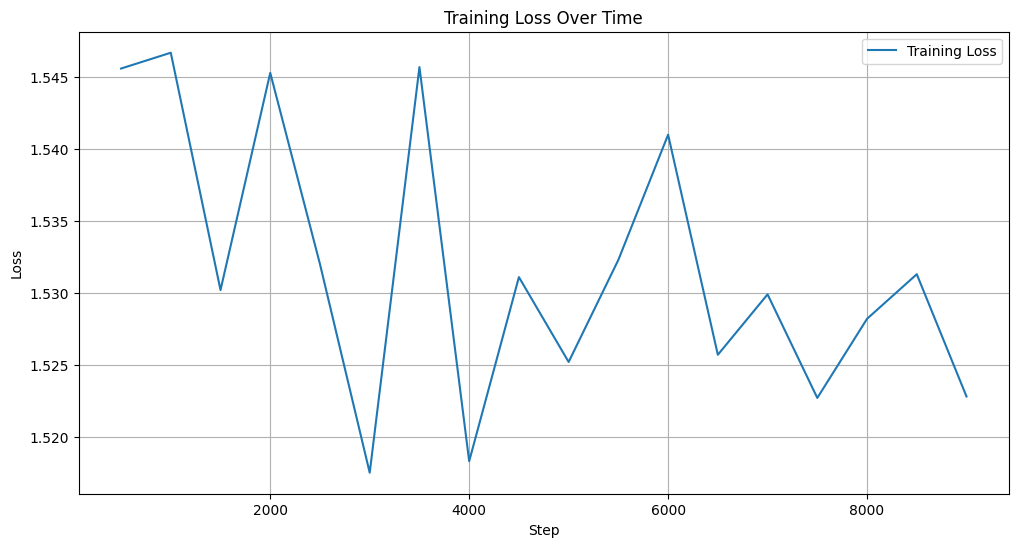

In [ ]:
import matplotlib.pyplot as plt

# Filter out the entries with training loss
train_loss_df = df[df['loss'].notna()][['step', 'loss']]
# Filter out the entries with evaluation loss
# eval_loss_df = df[df['eval_loss'].notna()][['step', 'eval_loss']]

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss')
# plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss')

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
eval_results = trainer.evaluate()

In [ ]:
eval_results

{'eval_loss': 1.7171573638916016,
 'eval_runtime': 9.2647,
 'eval_samples_per_second': 12.197,
 'eval_steps_per_second': 12.197,
 'epoch': 1.0}

In [ ]:
PrintTest("Introduction to Digital Transformation")

[{'generated_text': 'Introduction to Digital Transformation. What to 1111114 was in in a a apartment apartment? Which one is the one that would be an "?" and another one that would be an "?"\nWhat to Sing, what about 3500 B-722222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222232222322'}]


In [ ]:
PrintTest("Hello")

[{'generated_text': 'HelloHello Hellobye everyone everyone shout everyone at each time. Tony everyone at each good times everyone is there to _.\nA B A A A A A A B B C C C C C D D <|end|>'}]


In [ ]:
model.push_to_hub(REPO_NAME)

model.safetensors:   0%|          | 0.00/928M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/schuler/experimental-JP47D55/commit/79f49d0e7a51f9161b0ff1521fc14c7b1a691970', commit_message='Upload KPhi3ForCausalLM', commit_description='', oid='79f49d0e7a51f9161b0ff1521fc14c7b1a691970', pr_url=None, repo_url=RepoUrl('https://huggingface.co/schuler/experimental-JP47D55', endpoint='https://huggingface.co', repo_type='model', repo_id='schuler/experimental-JP47D55'), pr_revision=None, pr_num=None)

In [ ]:
# hf_tokenizer.push_to_hub(REPO_NAME)

In [ ]:
# model.eval(tokenized_datasets["validation"][0])